In [ ]:
import os
import warnings
from pathlib import Path
import json
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import simple_norm
from astropy import units as u

from matplotlib import pyplot as plt, colormaps
from photutils.aperture import aperture_photometry, CircularAnnulus

from jwst.combine_1d import Combine1dStep
from jwst.datamodels import MultiSpecModel

warnings.filterwarnings("ignore")
os.environ['CRDS_PATH'] = os.path.expanduser("~/crds_cache")
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# ------------------- User selects galaxy folder -------------------
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC1365")
galaxy_name = galaxy_folder.name

# Detect only the original 3 JWST channel cubes (end with _s3d.fits)
channel_files = sorted(galaxy_folder.glob("*_s3d.fits"))
if len(channel_files) != 3:
    raise ValueError(
        f"Galaxy folder must contain exactly 3 JWST MIRI cubes ending in '_s3d.fits'. "
        f"Found {len(channel_files)} files: {[f.name for f in channel_files]}"
    )

# Map them explicitly to CH1, CH2, CH3
channels = {
    'CH1': next(f for f in channel_files if "ch1" in f.name.lower()),
    'CH2': next(f for f in channel_files if "ch2" in f.name.lower()),
    'CH3': next(f for f in channel_files if "ch3" in f.name.lower()),
}

# ------------------- Parameters -------------------
pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41
pixel_scale_kpc = pixel_scale_pc / 1000.0

effective_fwhm = {'CH1': 0.22, 'CH2': 0.28, 'CH3': 0.66}  # arcsec
target_fwhm = 0.30  # arcsec

# helper: FWHM -> sigma (arcsec)
sigma_from_fwhm = lambda f: f / (2.0 * np.sqrt(2.0 * np.log(2.0)))

r0 = 0.9
step = 1.4
num_rings = 8
annuli_radii = [(r0 + i*step, r0 + (i+1)*step) for i in range(num_rings)]
    
# ------------------- Function to save ring -------------------
def save_ring(filename, wavelengths, flux):
    n = len(wavelengths)
    spec_table = Table()
    spec_table['WAVELENGTH'] = Column(wavelengths, unit='um')
    spec_table['FLUX'] = Column(flux, unit='MJy/sr')
    spec_table['FLUX_ERROR'] = Column(np.ones(n)*0.1, unit='MJy/sr')
    spec_table['DQ'] = np.zeros(n, dtype=np.uint32)
    for col in ['FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR',
                'SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON',
                'BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS']:
        spec_table[col] = np.zeros(n)
    model = MultiSpecModel()
    model.spec = [{"spec_table": spec_table}]
    model.meta.instrument.name = 'MIRI'
    model.meta.exposure.type = 'MIR_MRS'
    model.meta.exposure.exposure_time = 1.0
    model.meta.bunit_data = 'MJy/sr'
    model.save(filename, overwrite=True)
    print(f"[MultiSpecModel] Saved: {filename.name}")

# ------------------- Load cubes & PSF match -------------------
cubes = {}               # ch -> (cube[z,y,x], wavelengths)
collapsed_images = {}    # ch -> 2D mean image
min_shape = None

for ch, filename in channels.items():
    hdul = fits.open(filename)
    data = hdul[1].data.astype(np.float64)  # (nz, ny, nx)
    wl_start = hdul[1].header['CRVAL3']
    wl_step = hdul[1].header['CDELT3']
    wavelengths = wl_start + np.arange(data.shape[0]) * wl_step

    # PSF match up to target_fwhm if needed
    if effective_fwhm[ch] < target_fwhm:
        sigma_target = sigma_from_fwhm(target_fwhm)
        sigma_eff = sigma_from_fwhm(effective_fwhm[ch])
        sigma_conv_arcsec = np.sqrt(max(sigma_target**2 - sigma_eff**2, 0.0))
        sigma_pix = sigma_conv_arcsec / pixel_scale_arcsec
        data = np.array([
            convolve(slice, Gaussian2DKernel(sigma_pix), boundary='extend', nan_treatment='interpolate')
            for slice in data
        ])
        print(f"[{ch}] PSF matched to ~{target_fwhm}\"")

    collapsed = np.nanmean(data, axis=0)
    collapsed_images[ch] = collapsed

    if min_shape is None:
        min_shape = collapsed.shape
    else:
        min_shape = (min(min_shape[0], collapsed.shape[0]),
                     min(min_shape[1], collapsed.shape[1]))

    cubes[ch] = (data, wavelengths)

# Trim all to common min_shape (center crop)
for ch in collapsed_images:
    img = collapsed_images[ch]
    y_trim = (img.shape[0] - min_shape[0]) // 2
    x_trim = (img.shape[1] - min_shape[1]) // 2
    collapsed_images[ch] = img[y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]]
    cubes[ch] = (cubes[ch][0][:, y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]], cubes[ch][1])

# Compute common center in pixel coordinates
combined_image = sum(img - np.nanmin(img) for img in collapsed_images.values())
mask = np.isfinite(combined_image)
total = np.nansum(combined_image[mask])
y_idx, x_idx = np.indices(combined_image.shape)
x_center = np.nansum(x_idx[mask] * combined_image[mask]) / total
y_center = np.nansum(y_idx[mask] * combined_image[mask]) / total
print(f"[CENTER] x={x_center:.2f}, y={y_center:.2f}")

# ------------------- 2D plots: annuli overlaid on each channel -------------------
cmap = colormaps.get_cmap('hsv')
for ch in channels:
    collapsed = collapsed_images[ch]
    extent_x_kpc = collapsed.shape[1] * pixel_scale_kpc
    extent_y_kpc = collapsed.shape[0] * pixel_scale_kpc
    annuli_radii_kpc = [(r_in*pixel_scale_kpc, r_out*pixel_scale_kpc) for r_in, r_out in annuli_radii]

    plt.figure(figsize=(12, 8))
    norm = simple_norm(collapsed, 'sqrt', percent=88)
    plt.imshow(collapsed, origin='lower', cmap='binary', norm=norm,
               extent=[0, extent_x_kpc, 0, extent_y_kpc])
    plt.colorbar(label='MJy/sr')

    # plot annuli at the common center (converted to kpc)
    cx_kpc = x_center * pixel_scale_kpc
    cy_kpc = y_center * pixel_scale_kpc
    for i, (r_in_kpc, r_out_kpc) in enumerate(annuli_radii_kpc):
        ann = CircularAnnulus((cx_kpc, cy_kpc), r_in=r_in_kpc, r_out=r_out_kpc)
        ann.plot(color=cmap(i / len(annuli_radii)), lw=3, alpha=0.8)

    plt.scatter(cx_kpc, cy_kpc, color='red', s=100, marker='x', label='Center')
    plt.xlabel('RA (kpc)')
    plt.ylabel('Dec (kpc)')
    plt.title(f'{galaxy_name} - {ch} annuli (common FOV)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# ------------------- Extract annuli, save per-channel rings, and keep for pre-stitch plotting -------------------
pre_stitch_spectra = {ch: [] for ch in channels}  # store (wavelengths, flux, label)

for ch in cubes:
    data, wavelengths = cubes[ch]
    for i, (r_in, r_out) in enumerate(annuli_radii):
        ann_ap = CircularAnnulus((x_center, y_center), r_in=r_in, r_out=r_out)
        flux = np.array([aperture_photometry(slice, ann_ap)['aperture_sum'][0] for slice in data])

        ring_filename = galaxy_folder / f"{galaxy_name}_{ch}_Ring{i+1}.fits"
        save_ring(ring_filename, wavelengths, flux)

        pre_stitch_spectra[ch].append((wavelengths, flux, f'Ring {i+1}'))

# ------------------- Pre-stitch plots: per-channel annuli spectra -------------------
for ch in channels:
    plt.figure(figsize=(12, 8))
    for (wavelengths, flux, label) in pre_stitch_spectra[ch]:
        plt.plot(wavelengths, flux, label=label)
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Surface Brightness (MJy/sr)")
    plt.title(f"{galaxy_name} - {ch} annuli spectra (pre-stitch)")
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------- Stitch rings across CH1, CH2, CH3 -------------------
ch_labels = ['CH1', 'CH2', 'CH3']  # order for stitching

for ring_number in range(1, num_rings+1):
    input_files = [
        str(galaxy_folder / f"{galaxy_name}_{ch}_Ring{ring_number}.fits")
        for ch in ch_labels
    ]
    stitched_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}.fits"
    json_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}.json"

    association = {
        "asn_type": "spec",
        "asn_rule": "combine1d",
        "asn_id": f"a{galaxy_name}_Ring{ring_number}",
        "program": "12345",
        "target": galaxy_name,
        "asn_pool": "auto-gen",
        "version_id": "1.0",
        "products": [{
            "name": f"{galaxy_name}_Ring{ring_number}",
            "members": [{"expname": file, "exptype": "science"} for file in input_files]
        }]
    }

    with open(json_file, "w") as f:
        json.dump(association, f, indent=4)

    print(f"[Combine1dStep] Stitching: {input_files}")
    Combine1dStep.call(
    json_file,
    output_file=stitched_file,
    output_dir=str(galaxy_folder),
    suffix="stitched"
)


# ------------------- Simplified 1D spectra (PAHFIT-ready) -------------------
for ring_number in range(1, num_rings+1):
    stitched_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_stitched.fits"
    simplified_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_1dspec.fits"

    if not stitched_file.exists():
        print(f"[SKIP] Missing stitched file: {stitched_file.name}")
        continue

    model = MultiSpecModel(str(stitched_file))
    table = model.spec[0].spec_table
    wavelength = u.Quantity(table["WAVELENGTH"], unit=u.um)
    flux = u.Quantity(table["FLUX"], unit=u.MJy/u.sr)

    tab = Table()
    tab['wavelength'] = Column(wavelength, unit='um')
    tab['flux'] = Column(flux, unit='MJy/sr')
    tab.write(simplified_file, format='fits', overwrite=True)

    print(f"[PAHFIT-READY] Saved: {simplified_file.name}")

# ------------------- Plot stitched ring spectra (one plot per ring) -------------------
for ring_number in range(1, num_rings+1):
    spec_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_1dspec.fits"
    if not spec_file.exists():
        print(f"[SKIP] Missing: {spec_file.name}")
        continue

    table = Table.read(spec_file, hdu=1)
    wavelength = table['wavelength']
    flux = table['flux']

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength, flux, color='tab:blue')
    plt.xlabel("Wavelength (μm)", fontsize=14)
    plt.ylabel("Surface Brightness (MJy/sr)", fontsize=14)
    plt.title(f"{galaxy_name} - Ring {ring_number} stitched spectrum", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[INFO] Found 9 cube(s) in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469:
 - jw01328-c1006_t014_miri_ch1-long_s3d.fits
 - jw01328-c1006_t014_miri_ch1-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch1-short_s3d.fits
 - jw01328-c1006_t014_miri_ch2-long_s3d.fits
 - jw01328-c1006_t014_miri_ch2-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch2-short_s3d.fits
 - jw01328-c1006_t014_miri_ch3-long_s3d.fits
 - jw01328-c1006_t014_miri_ch3-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch3-short_s3d.fits
[INFO] Available mini-cubes:
  ('CH1', 'short'): jw01328-c1006_t014_miri_ch1-short_s3d.fits
  ('CH1', 'medium'): jw01328-c1006_t014_miri_ch1-medium_s3d.fits
  ('CH1', 'long'): jw01328-c1006_t014_miri_ch1-long_s3d.fits
  ('CH2', 'short'): jw01328-c1006_t014_miri_ch2-short_s3d.fits
  ('CH2', 'medium'): jw01328-c1006_t014_miri_ch2-medium_s3d.fits
  ('CH2', 'long'): jw01328-c1006_t014_miri_ch2-long_s3d.fits
  ('CH3', 'short'): jw01328-c1006_t014_miri_ch3-short_s3d.fits
  ('CH3', 'medium'): jw01

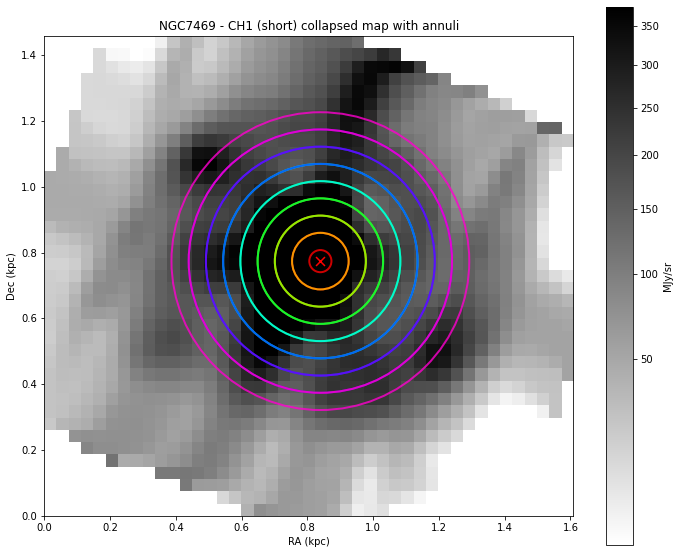

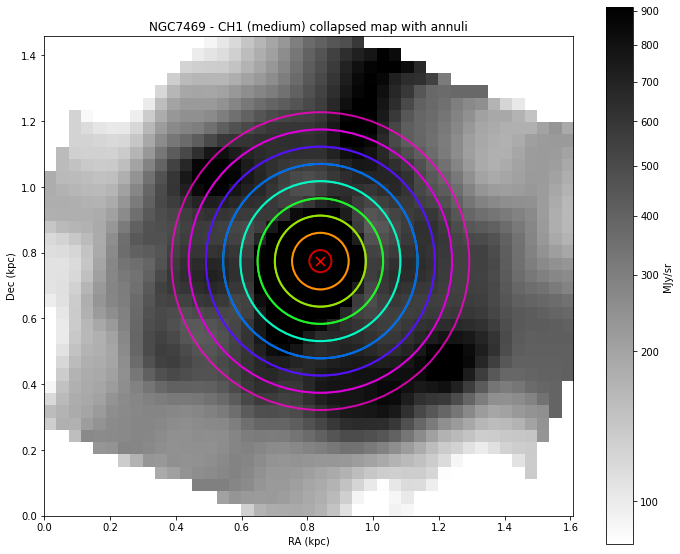

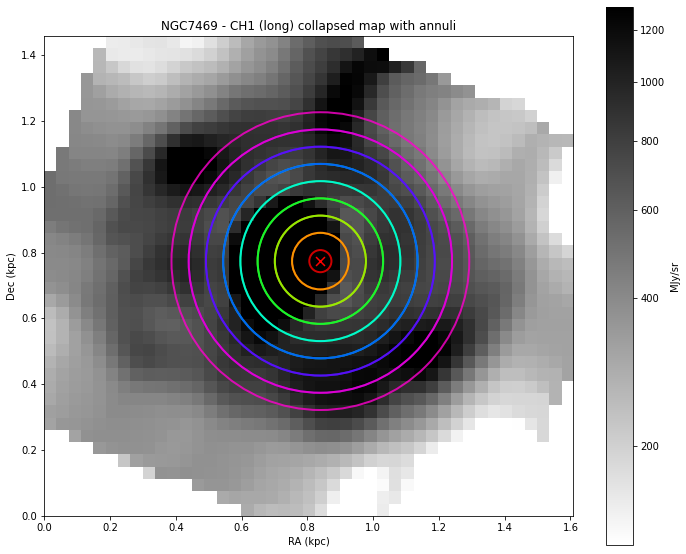

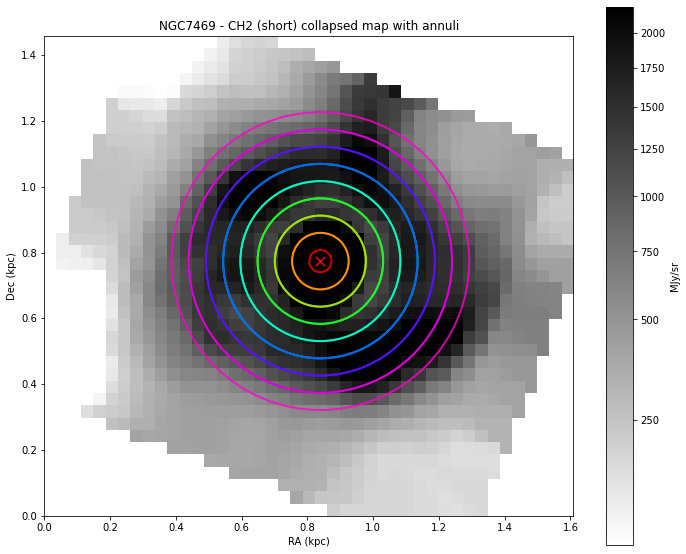

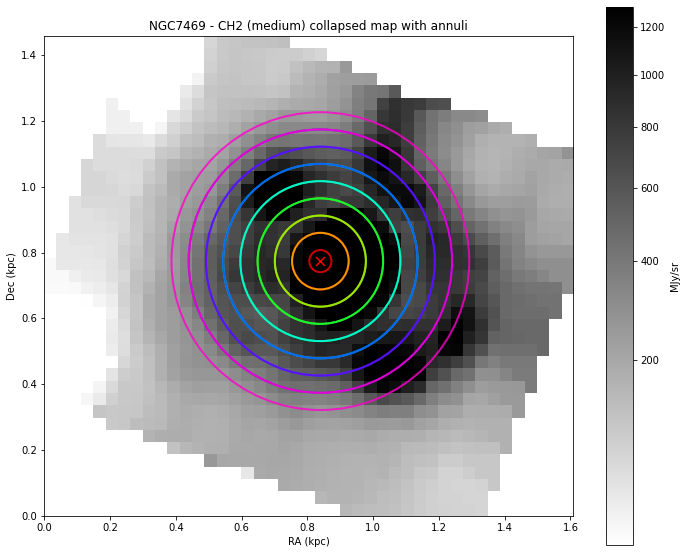

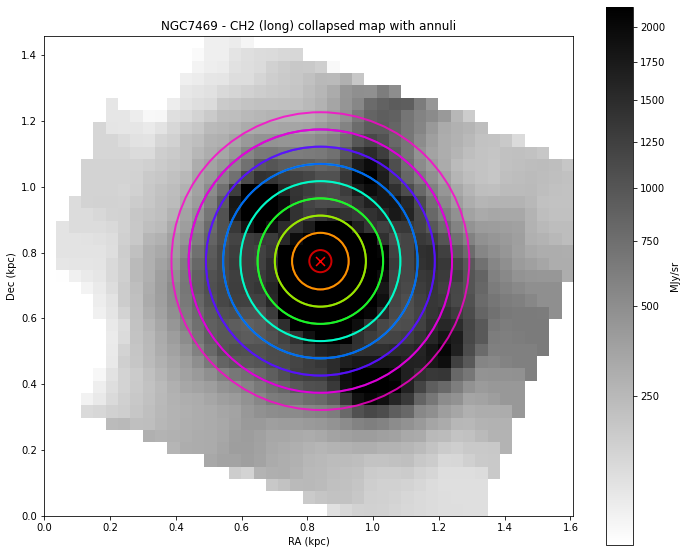

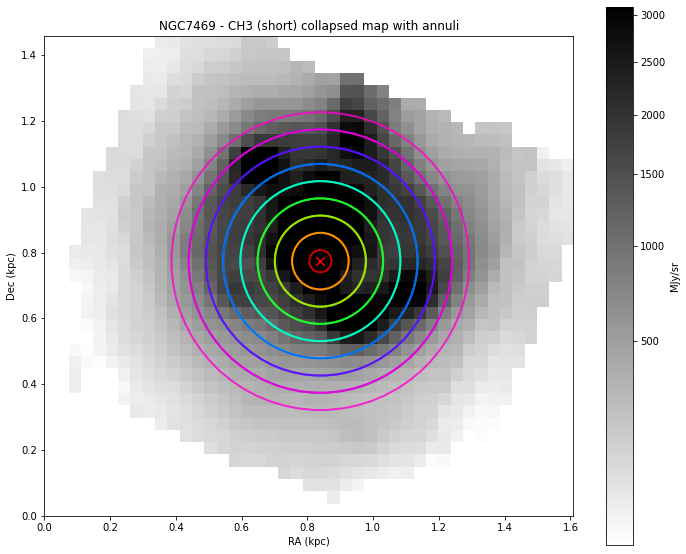

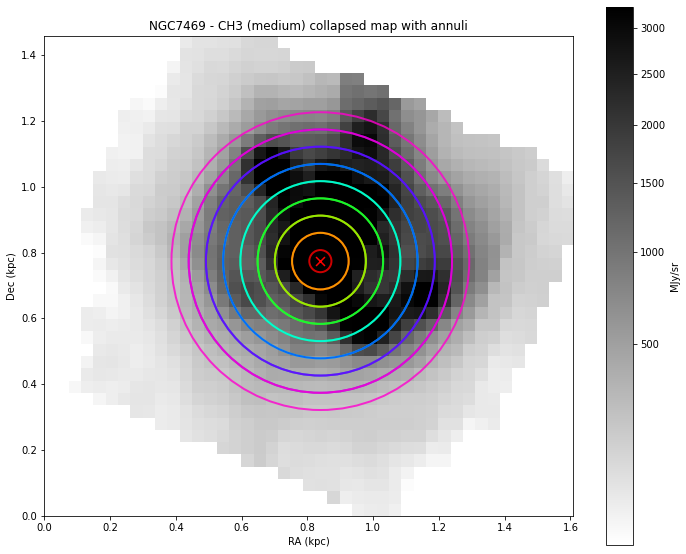

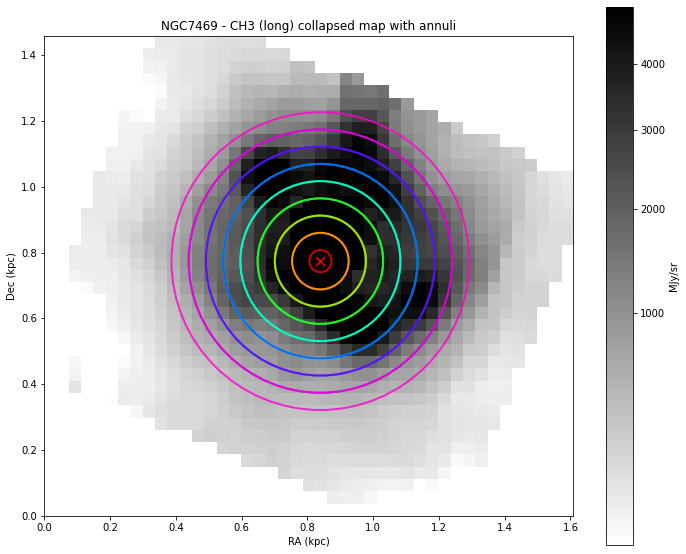

[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-long_Ring1.fits
[Mu

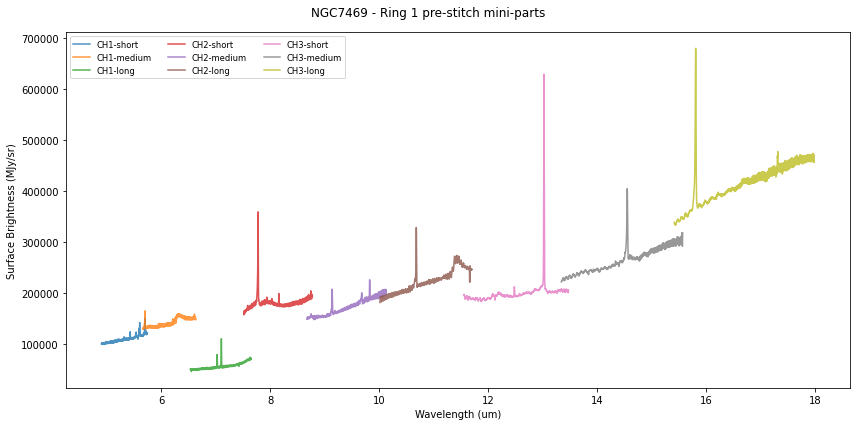

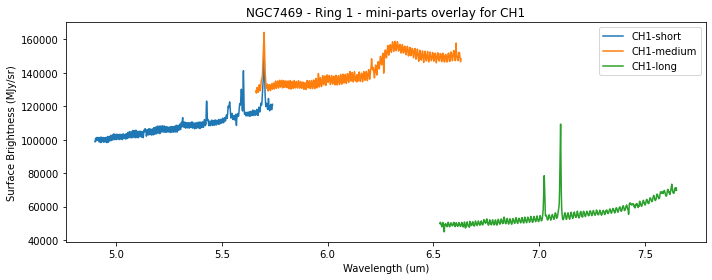

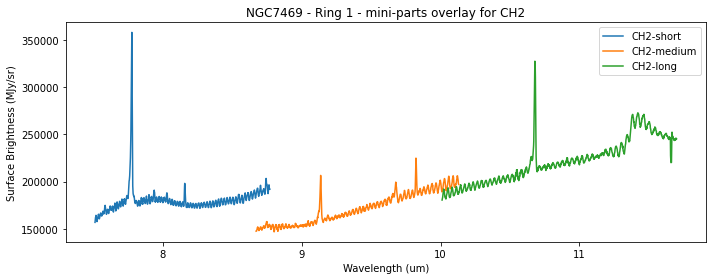

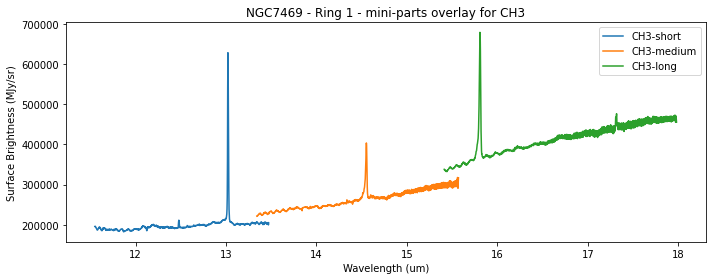

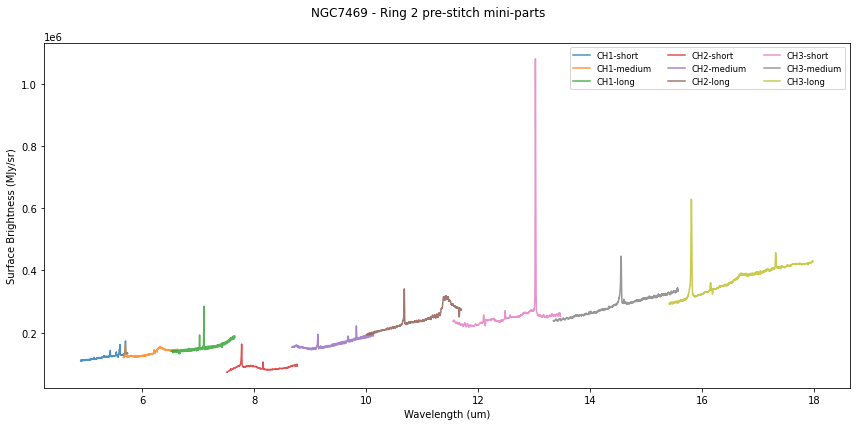

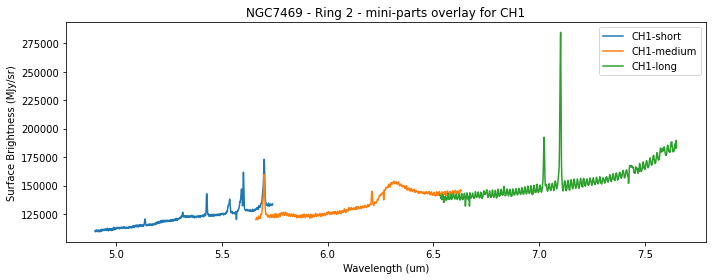

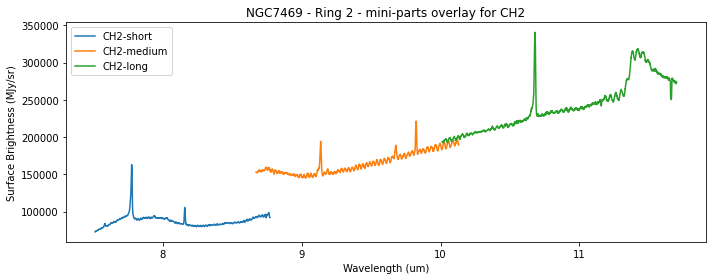

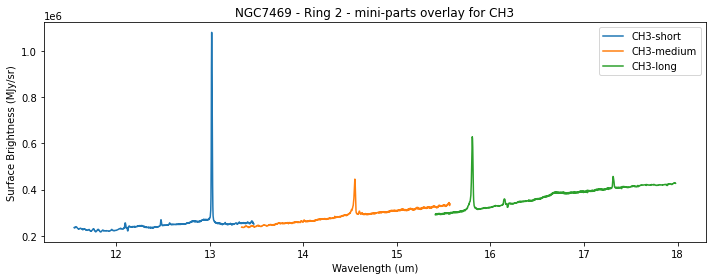

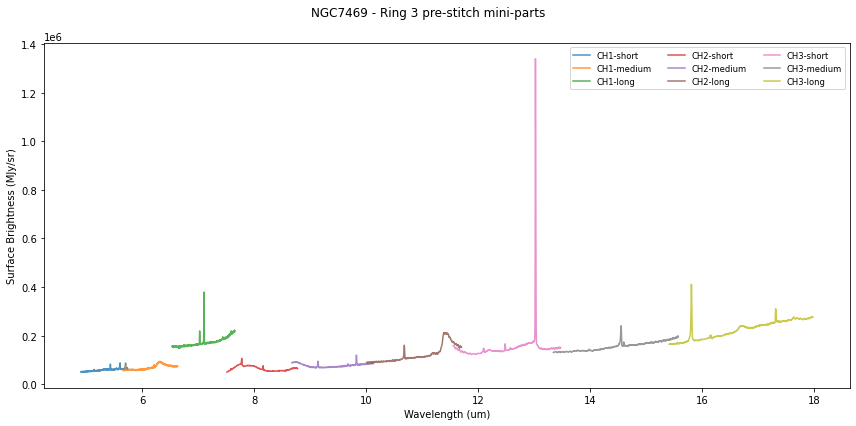

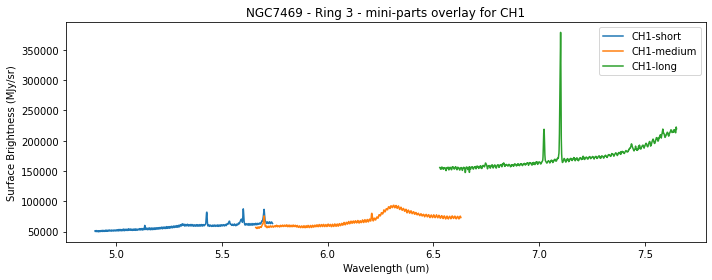

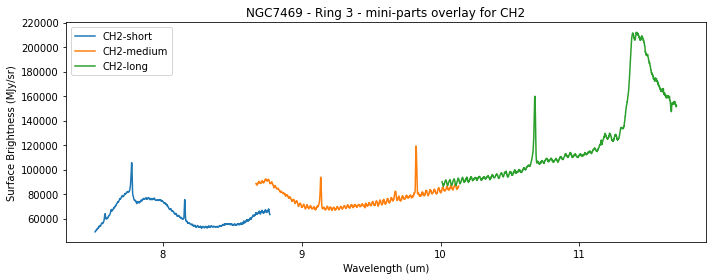

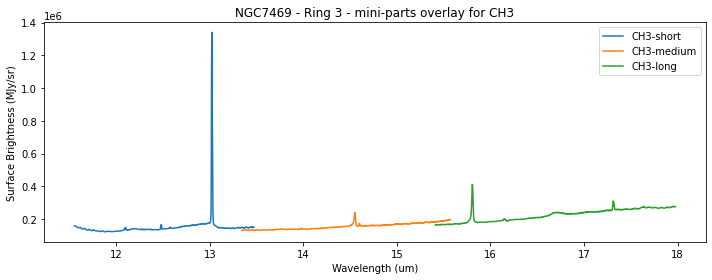

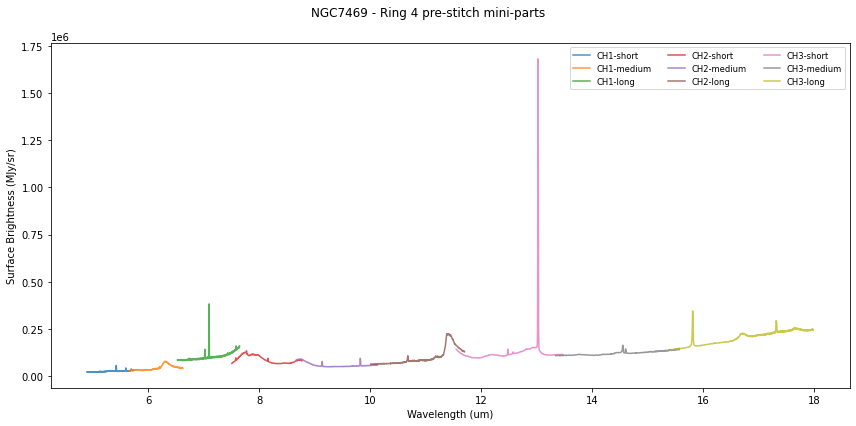

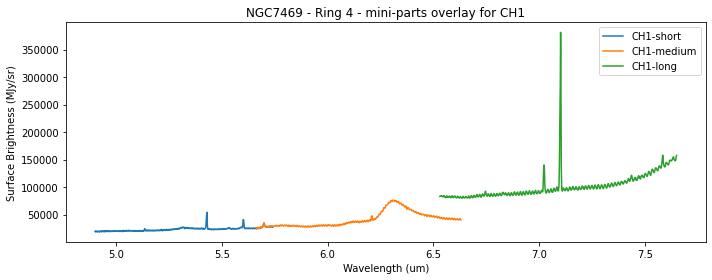

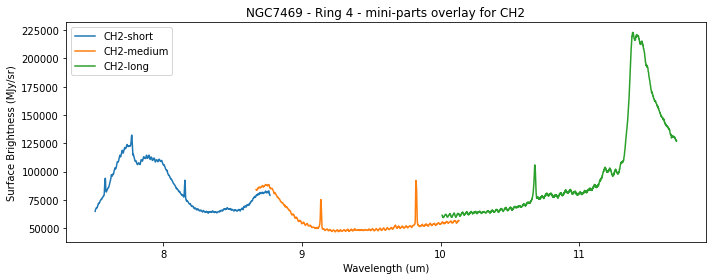

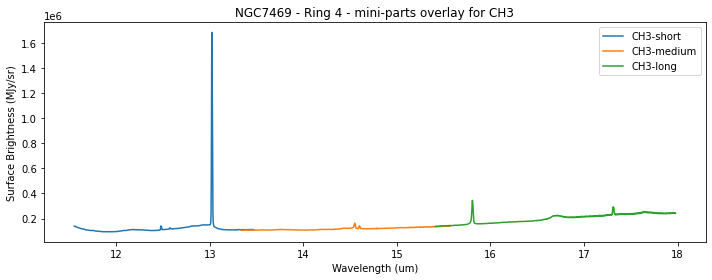

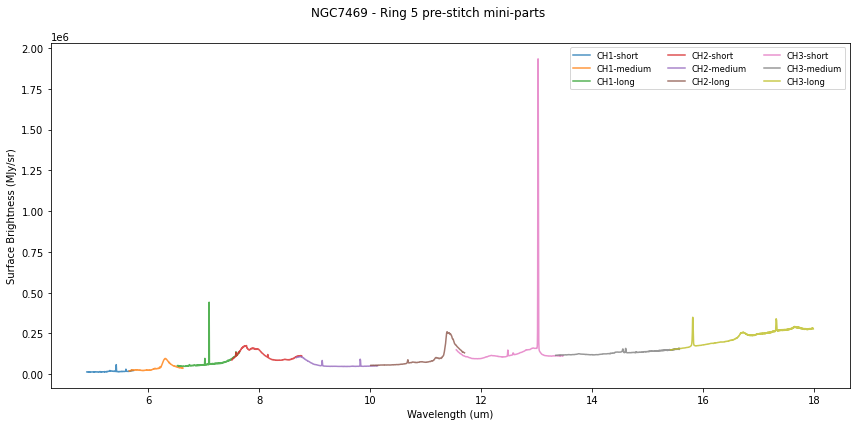

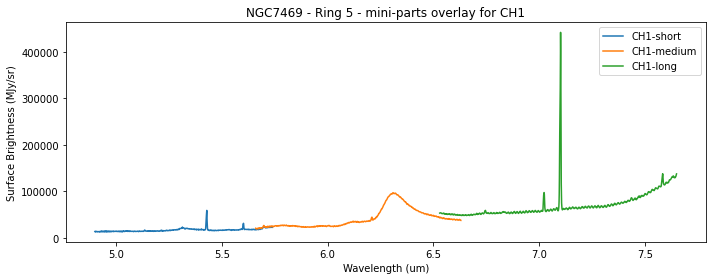

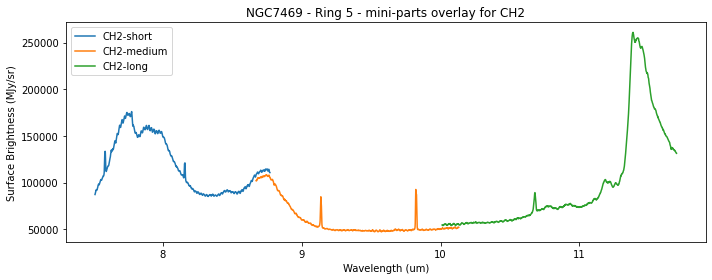

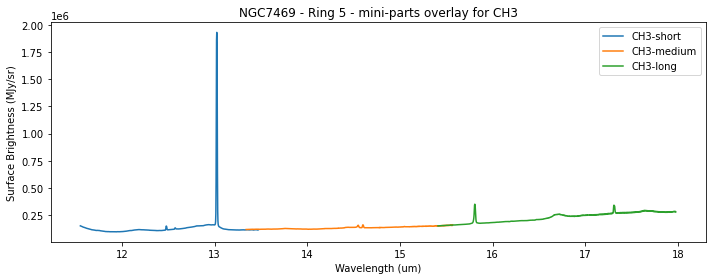

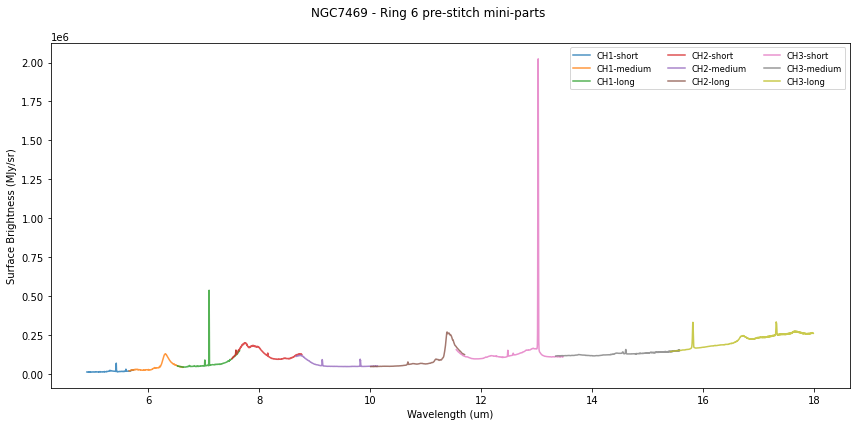

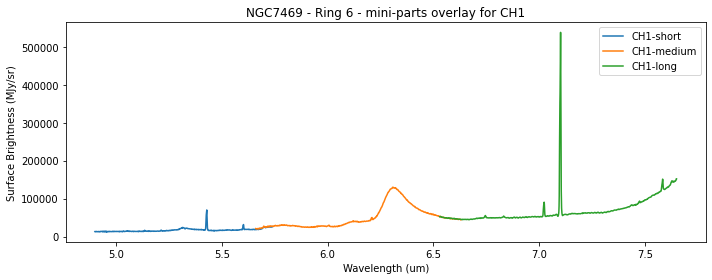

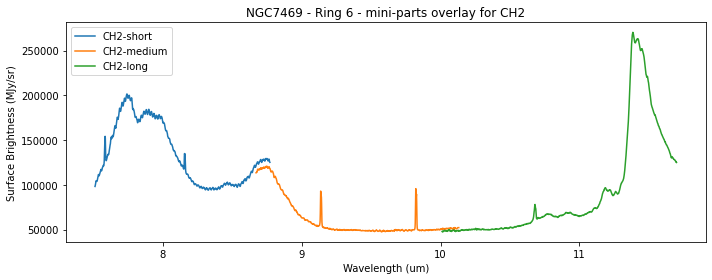

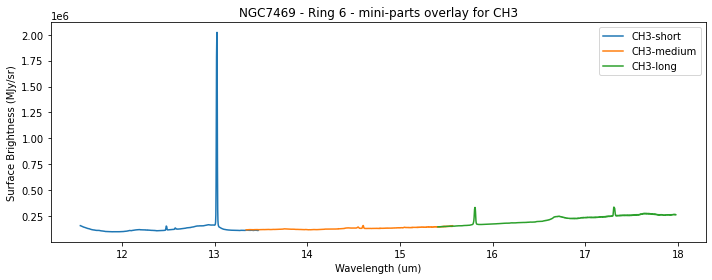

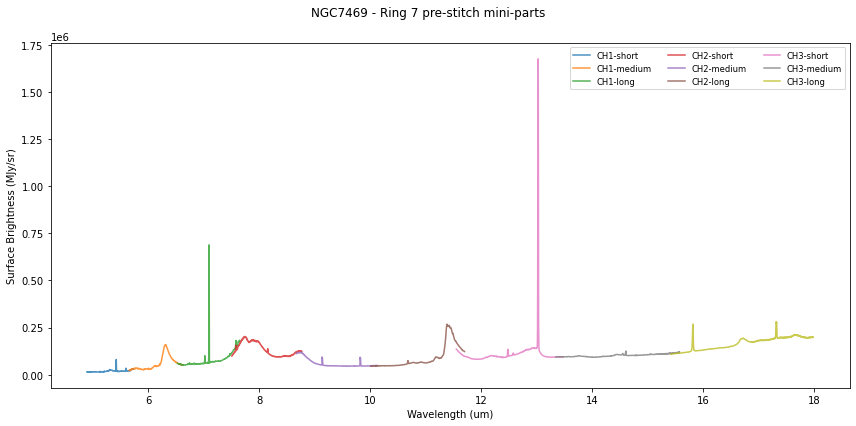

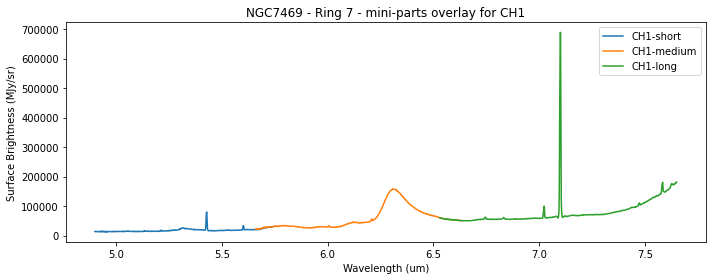

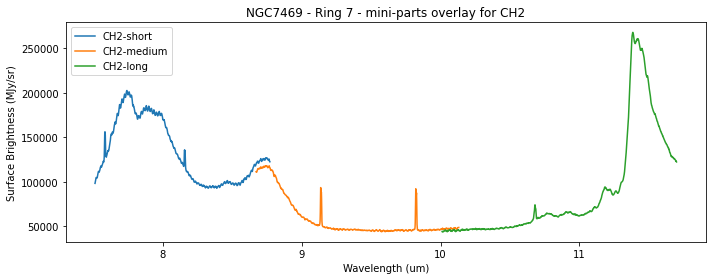

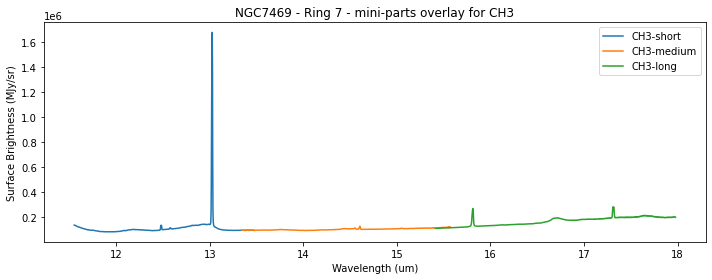

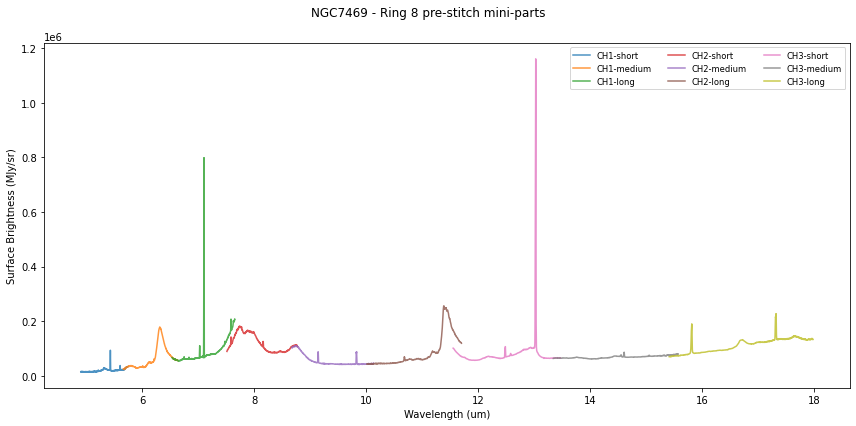

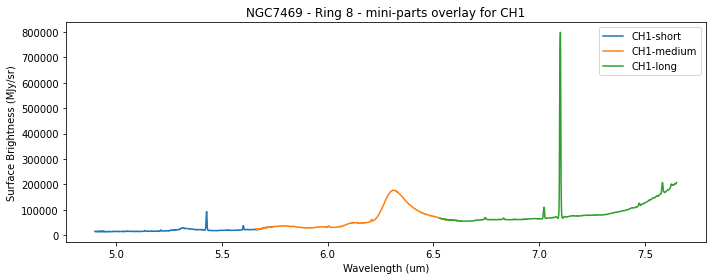

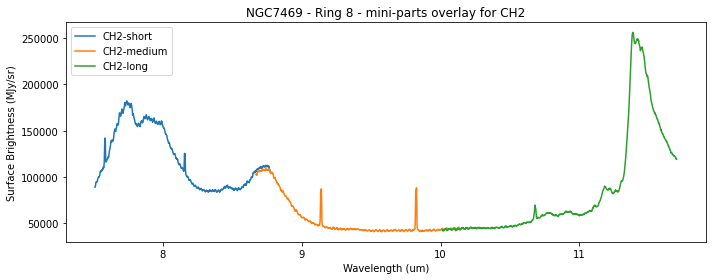

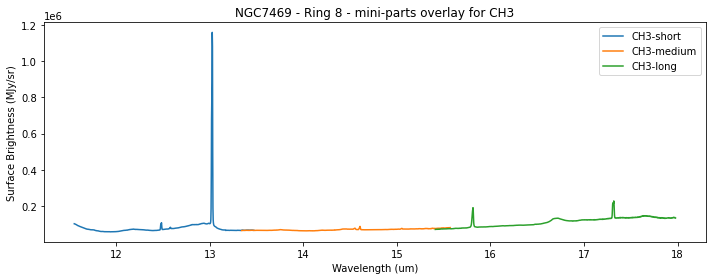

[INFO] Starting one-step stitching (all mini-parts) per ring ...
[Combine1dStep] Stitching ring 1 -> NGC7469_Ring1_stitched.fits


2025-10-07 07:30:12,615 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:12,817 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring1.json'),).
2025-10-07 07:30:12,819 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring1_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:13,688 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:13,690 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring1_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring1_1dspec.fits


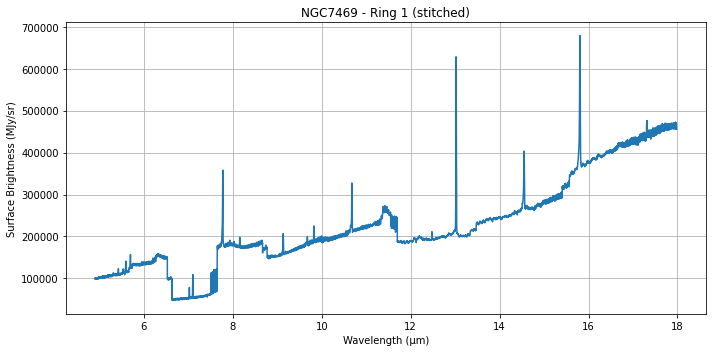

[Combine1dStep] Stitching ring 2 -> NGC7469_Ring2_stitched.fits


2025-10-07 07:30:15,561 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:15,757 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring2.json'),).
2025-10-07 07:30:15,759 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring2_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:16,620 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:16,621 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring2_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring2_1dspec.fits


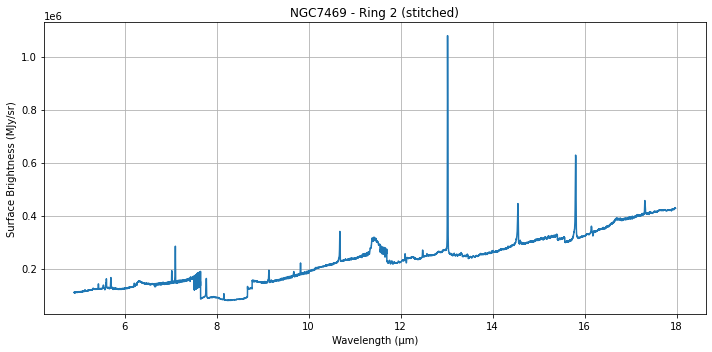

[Combine1dStep] Stitching ring 3 -> NGC7469_Ring3_stitched.fits


2025-10-07 07:30:18,507 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:18,702 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring3.json'),).
2025-10-07 07:30:18,704 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring3_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:19,583 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:19,585 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring3_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring3_1dspec.fits


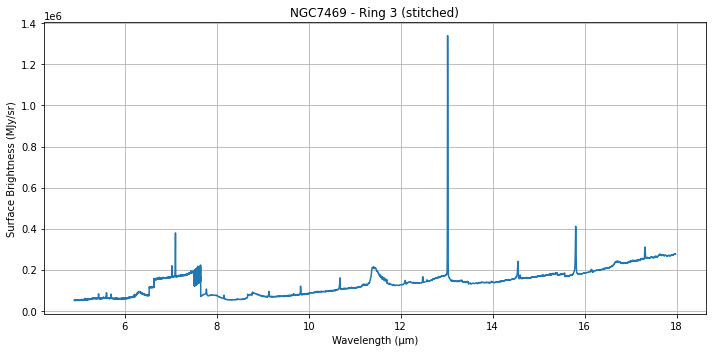

[Combine1dStep] Stitching ring 4 -> NGC7469_Ring4_stitched.fits


2025-10-07 07:30:21,497 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:21,694 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring4.json'),).
2025-10-07 07:30:21,697 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring4_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:22,577 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:22,578 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring4_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring4_1dspec.fits


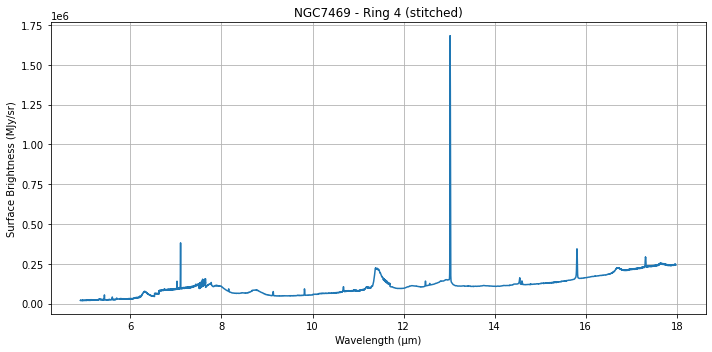

[Combine1dStep] Stitching ring 5 -> NGC7469_Ring5_stitched.fits


2025-10-07 07:30:24,507 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:24,728 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring5.json'),).
2025-10-07 07:30:24,730 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring5_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:25,584 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:25,586 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring5_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring5_1dspec.fits


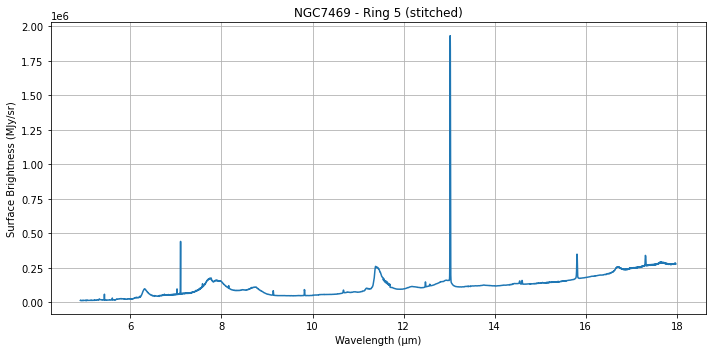

[Combine1dStep] Stitching ring 6 -> NGC7469_Ring6_stitched.fits


2025-10-07 07:30:27,488 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:27,716 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring6.json'),).
2025-10-07 07:30:27,720 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring6_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:28,802 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:28,803 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring6_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring6_1dspec.fits


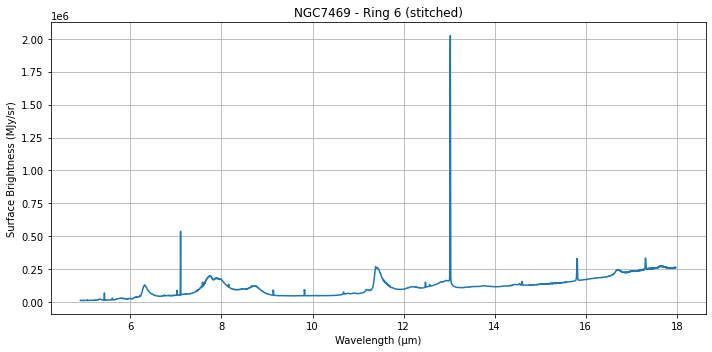

[Combine1dStep] Stitching ring 7 -> NGC7469_Ring7_stitched.fits


2025-10-07 07:30:30,726 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:30,956 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring7.json'),).
2025-10-07 07:30:30,958 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring7_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:31,854 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:31,855 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring7_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring7_1dspec.fits


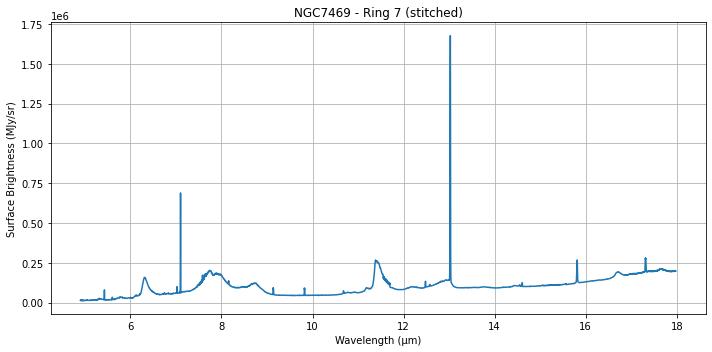

[Combine1dStep] Stitching ring 8 -> NGC7469_Ring8_stitched.fits


2025-10-07 07:30:33,766 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2025-10-07 07:30:33,966 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args (WindowsPath('C:/Users/Juan/Downloads/Research/JWSTPAH/3_Hydrocarbons/NGC7469/NGC7469_Ring8.json'),).
2025-10-07 07:30:33,969 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469\\NGC7469_Ring8_stitched.fits', 'output_dir': 'C:\\Users\\Juan\\Downloads\\Research\\JWSTPAH\\3_Hydrocarbons\\NGC7469', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}
2025-10-07 07:30:34,873 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2025-10-07 07:30:34,876 - stpipe.Combine1dStep - WARNING - There is no WCS in the inpu

[INFO] Using stitched file found: NGC7469_Ring8_stitched_combine1dstep.fits
[PAHFIT-READY] Saved: NGC7469_Ring8_1dspec.fits


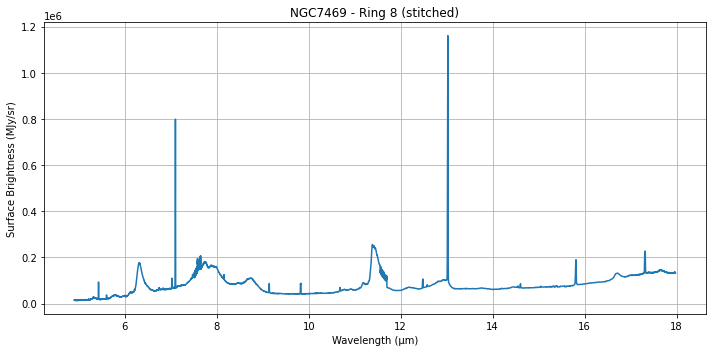

[DONE] All rings processed.


In [5]:
#!/usr/bin/env python3
"""
Unified extraction + one-step stitching script.
- Select galaxy_folder (contains the _s3d.fits cubes: CH1/CH2/CH3 with short/medium/long or combined).
- Script extracts annuli from every mini-cube, saves MultiSpecModel rings,
  stitches ALL available mini-parts per ring in one Combine1dStep call,
  writes simplified 1D PAHFIT-ready FITS, and shows diagnostics.
"""

import os
import json
import warnings
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import simple_norm
from astropy import units as u

import matplotlib.pyplot as plt
from matplotlib import colormaps
from photutils.aperture import aperture_photometry, CircularAnnulus

from jwst.combine_1d import Combine1dStep
from jwst.datamodels import MultiSpecModel

warnings.filterwarnings("ignore")

# ------------------- USER: select galaxy folder here -------------------
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name = galaxy_folder.name

# environment for JWST (optional)
os.environ['CRDS_PATH'] = os.path.expanduser("~/crds_cache")
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# ------------------- PARAMETERS (keep as before) -------------------
pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41
pixel_scale_kpc = pixel_scale_pc / 1000.0

effective_fwhm = {'CH1': 0.22, 'CH2': 0.28, 'CH3': 0.66}  # arcsec
target_fwhm = 0.30  # arcsec
sigma_from_fwhm = lambda f: f / (2.0 * np.sqrt(2.0 * np.log(2.0)))

r0 = 0.9
step = 1.4
num_rings = 8
annuli_radii = [(r0 + i*step, r0 + (i+1)*step) for i in range(num_rings)]

# order for final stitching (per-ring): CH1 short/med/long, CH2..., CH3...
stitch_order = [
    ('CH1','short'), ('CH1','medium'), ('CH1','long'),
    ('CH2','short'), ('CH2','medium'), ('CH2','long'),
    ('CH3','short'), ('CH3','medium'), ('CH3','long'),
]

# ------------------- Helper: find cube for (channel, part) -------------------
def find_cube_for(ch_label, part_label, all_files):
    """
    Look for a filename in all_files that corresponds to channel ch_label ('CH1') and part_label ('short','medium','long').
    Accepts names containing 'ch1' (case-insensitive) and 'short' (or 'shortmediumlong' or 's3d' combos).
    Returns Path or None.
    """
    ch_frag = ch_label.lower()  # 'ch1'
    part_frag = part_label.lower()  # 'short'
    # Look for exact match first (both substrings present)
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and part_frag in name:
            return f
    # If no exact, allow 'shortmediumlong' full-band to satisfy any part
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and ('shortmediumlong' in name or 'shortmedlong' in name or 'shortmedium' in name):
            return f
    # No file
    return None

# ------------------- Function to save ring as MultiSpecModel -------------------
def save_ring_multispec(filename_path: Path, wavelengths, flux):
    n = len(wavelengths)
    spec_table = Table()
    spec_table['WAVELENGTH'] = Column(wavelengths, unit='um')
    spec_table['FLUX'] = Column(flux, unit='MJy/sr')
    spec_table['FLUX_ERROR'] = Column(np.ones(n)*0.1, unit='MJy/sr')
    spec_table['DQ'] = np.zeros(n, dtype=np.uint32)
    for col in ['FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR',
                'SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON',
                'BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS']:
        spec_table[col] = np.zeros(n)
    model = MultiSpecModel()
    model.spec = [{"spec_table": spec_table}]
    model.meta.instrument.name = 'MIRI'
    model.meta.exposure.type = 'MIR_MRS'
    model.meta.exposure.exposure_time = 1.0
    model.meta.bunit_data = 'MJy/sr'
    model.save(str(filename_path), overwrite=True)
    print(f"[MultiSpecModel] Saved: {filename_path.name}")

# ------------------- Gather available cubes -------------------
all_cube_files = sorted(galaxy_folder.glob("*_s3d.fits"))
if len(all_cube_files) == 0:
    raise FileNotFoundError(f"No '*_s3d.fits' files found in {galaxy_folder}")

print(f"[INFO] Found {len(all_cube_files)} cube(s) in {galaxy_folder}:")
for f in all_cube_files:
    print(" -", f.name)

# Build a lookup of available mini-cubes per (CHx, part)
mini_cubes = {}  # key (CH1,'short') -> Path
for ch, part in stitch_order:
    found = find_cube_for(ch, part, all_cube_files)
    if found is not None:
        mini_cubes[(ch, part)] = found

# Also allow detection of 'CH1' full-band files (shortmediumlong)
for f in all_cube_files:
    name = f.name.lower()
    if 'ch1' in name and 'shortmediumlong' in name:
        mini_cubes[('CH1','full')] = f
    if 'ch2' in name and 'shortmediumlong' in name:
        mini_cubes[('CH2','full')] = f
    if 'ch3' in name and 'shortmediumlong' in name:
        mini_cubes[('CH3','full')] = f

print("[INFO] Available mini-cubes:")
for k,v in mini_cubes.items():
    print(f"  {k}: {v.name}")

# ------------------- Load all mini-cubes: extract data, wavelengths, collapsed image -------------------
cubes = {}             # key -> (data[z,y,x], wavelengths array in um)
collapsed_map = {}     # key -> 2D collapsed mean
min_shape = None

for (ch, part), filepath in mini_cubes.items():
    hdul = fits.open(filepath)
    data = hdul[1].data.astype(np.float64)  # (nz, ny, nx)
    header = hdul[1].header
    wl_start = header.get('CRVAL3', header.get('CRVAL', None))
    wl_step  = header.get('CDELT3', header.get('CDELT', None))
    if wl_start is None or wl_step is None:
        # try alternative header keywords; fail if not found
        raise KeyError(f"No CRVAL3/CDELT3 in header of {filepath.name}")
    wavelengths = wl_start + np.arange(data.shape[0]) * wl_step
    # PSF match if necessary based on channel (use channel's effective_fwhm)
    eff_fwhm = effective_fwhm.get(ch, None)
    if eff_fwhm is not None and eff_fwhm < target_fwhm:
        sigma_target = sigma_from_fwhm(target_fwhm)
        sigma_eff = sigma_from_fwhm(eff_fwhm)
        sigma_conv_arcsec = np.sqrt(max(sigma_target**2 - sigma_eff**2, 0.0))
        sigma_pix = sigma_conv_arcsec / pixel_scale_arcsec
        data = np.array([
            convolve(plane, Gaussian2DKernel(sigma_pix), boundary='extend', nan_treatment='interpolate')
            for plane in data
        ])
        print(f"[{ch}|{part}] PSF matched -> target {target_fwhm}\" (sigma_pix={sigma_pix:.3f})")
    collapsed = np.nanmean(data, axis=0)
    cubes[(ch,part)] = (data, wavelengths)
    collapsed_map[(ch,part)] = collapsed
    if min_shape is None:
        min_shape = collapsed.shape
    else:
        min_shape = (min(min_shape[0], collapsed.shape[0]),
                     min(min_shape[1], collapsed.shape[1]))

# Center-crop all collapsed maps & cube data to min_shape
for key in list(collapsed_map.keys()):
    img = collapsed_map[key]
    y_trim = (img.shape[0] - min_shape[0]) // 2
    x_trim = (img.shape[1] - min_shape[1]) // 2
    collapsed_map[key] = img[y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]]
    data, wl = cubes[key]
    cubes[key] = (data[:, y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]], wl)

# ------------------- Compute common photometric center from combined image -------------------
combined_image = sum(img - np.nanmin(img) for img in collapsed_map.values())
mask = np.isfinite(combined_image)
total = np.nansum(combined_image[mask])
y_idx, x_idx = np.indices(combined_image.shape)
x_center = np.nansum(x_idx[mask] * combined_image[mask]) / total
y_center = np.nansum(y_idx[mask] * combined_image[mask]) / total
print(f"[CENTER] common center (px): x={x_center:.2f}, y={y_center:.2f}")

# ------------------- 2D visualization: show collapsed maps with annuli (per mini-cube) -------------------
cmap = colormaps.get_cmap('hsv')
for key, img in collapsed_map.items():
    ch, part = key
    plt.figure(figsize=(10,8))
    norm = simple_norm(img, 'sqrt', percent=88)
    extent_x_kpc = img.shape[1] * pixel_scale_kpc
    extent_y_kpc = img.shape[0] * pixel_scale_kpc
    plt.imshow(img, origin='lower', cmap='binary', norm=norm,
               extent=[0, extent_x_kpc, 0, extent_y_kpc])
    plt.colorbar(label='MJy/sr')
    # plot annuli in kpc coordinates
    annuli_kpc = [(r_in*pixel_scale_kpc, r_out*pixel_scale_kpc) for r_in,r_out in annuli_radii]
    cx_kpc = x_center * pixel_scale_kpc
    cy_kpc = y_center * pixel_scale_kpc
    for i,(rin, rout) in enumerate(annuli_kpc):
        ann = CircularAnnulus((cx_kpc, cy_kpc), r_in=rin, r_out=rout)
        ann.plot(color=cmap(i/len(annuli_kpc)), lw=2, alpha=0.8)
    plt.scatter(cx_kpc, cy_kpc, color='red', marker='x', s=80)
    plt.title(f"{galaxy_name} - {ch} ({part}) collapsed map with annuli")
    plt.xlabel("RA (kpc)")
    plt.ylabel("Dec (kpc)")
    plt.tight_layout()
    plt.show()

# ------------------- Extract annuli from each mini-cube and save MultiSpecModel rings -------------------
print("[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...")
for (ch, part), (data, wavelengths) in cubes.items():
    for i, (r_in, r_out) in enumerate(annuli_radii):
        ann_ap = CircularAnnulus((x_center, y_center), r_in=r_in, r_out=r_out)
        flux = np.array([aperture_photometry(plane, ann_ap)['aperture_sum'][0] for plane in data])
        ring_idx = i+1
        # filename pattern: GALAXY_CH1-short_Ring1.fits
        ring_filename = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_idx}.fits"
        save_ring_multispec(ring_filename, wavelengths, flux)

# ------------------- Pre-stitch plots: show mini-parts for a chosen ring (and overlay per channel) -------------------
# (Plot per ring across mini-parts to inspect continuity.)
for ring_number in range(1, num_rings+1):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{galaxy_name} - Ring {ring_number} pre-stitch mini-parts")
    ax1 = plt.subplot(1,1,1)
    for (ch, part), (data, wavelengths) in cubes.items():
        # read the saved MultiSpecModel ring file to get flux (or recompute directly)
        ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if not ring_file.exists():
            continue
        model = MultiSpecModel(str(ring_file))
        tbl = model.spec[0].spec_table
        wl = tbl['WAVELENGTH']
        fl = tbl['FLUX']
        ax1.plot(wl, fl, label=f"{ch}-{part}", alpha=0.8)
    ax1.set_xlabel("Wavelength (um)")
    ax1.set_ylabel("Surface Brightness (MJy/sr)")
    ax1.legend(ncol=3, fontsize='small')
    plt.tight_layout()
    plt.show()

    # Overlay per channel (CH1 parts together etc.)
    for ch in ['CH1','CH2','CH3']:
        plt.figure(figsize=(10,4))
        for part in ['short','medium','long','full']:
            ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
            if not ring_file.exists():
                # also accept "full" naming without '-full' if file existed as CH1_shortmediumlong
                continue
            model = MultiSpecModel(str(ring_file))
            tbl = model.spec[0].spec_table
            plt.plot(tbl['WAVELENGTH'], tbl['FLUX'], label=f"{ch}-{part}")
        plt.title(f"{galaxy_name} - Ring {ring_number} - mini-parts overlay for {ch}")
        plt.xlabel("Wavelength (um)")
        plt.ylabel("Surface Brightness (MJy/sr)")
        plt.legend()
        plt.tight_layout()
        plt.show()

# ------------------- ONE-STEP STITCHING: stitch ALL available mini-parts for each ring at once -------------------
print("[INFO] Starting one-step stitching (all mini-parts) per ring ...")
for ring_number in range(1, num_rings+1):
    # collect input files in the desired stitch_order if they exist
    input_files = []
    for ch, part in stitch_order:
        file_candidate = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if file_candidate.exists():
            input_files.append(str(file_candidate))
        else:
            # allow presence of full-band file
            full_candidate = None
            for suffix in ('full','shortmediumlong','shortmedlong'):
                full_candidate = galaxy_folder / f"{galaxy_name}_{ch}-{suffix}_Ring{ring_number}.fits"
                if full_candidate.exists():
                    input_files.append(str(full_candidate))
                    break
            # if still not found, continue (we will stitch whatever we have)
    if len(input_files) == 0:
        print(f"[SKIP] No mini-part ring files found for Ring {ring_number}; skipping stitching.")
        continue

    stitched_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_stitched.fits"
    json_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}.json"

    association = {
        "asn_type": "spec",
        "asn_rule": "combine1d",
        "asn_id": f"a{galaxy_name}_Ring{ring_number}",
        "program": "12345",
        "target": galaxy_name,
        "asn_pool": "auto-gen",
        "version_id": "1.0",
        "products": [
            {
                "name": f"{galaxy_name}_Ring{ring_number}",
                "members": [{"expname": f, "exptype": "science"} for f in input_files]
            }
        ]
    }

    with open(json_file, "w") as f:
        json.dump(association, f, indent=2)

    print(f"[Combine1dStep] Stitching ring {ring_number} -> {stitched_file.name}")
    try:
        Combine1dStep.call(json_file, output_file=str(stitched_file), output_dir=str(galaxy_folder))
    except Exception as e:
        # print error but try to find any created stitched file
        print(f"[ERROR] Combine1dStep failed for Ring {ring_number}: {e}")
    # try to locate stitched file if Combine1dStep produced a differently named file
    if not stitched_file.exists():
        # search for something that starts with galaxy_name_Ring{ring_number} and contains 'stitc' or 'combine1d'
        candidates = list(galaxy_folder.glob(f"{galaxy_name}_Ring{ring_number}*"))
        stitched_candidates = [c for c in candidates if 'stitc' in c.name.lower() or 'combine1d' in c.name.lower() or c.name.endswith('.fits')]
        stitched_file = stitched_candidates[0] if stitched_candidates else None
        if stitched_file is None:
            print(f"[WARN] Could not find stitched output for Ring {ring_number} after Combine1dStep.")
            continue
        else:
            print(f"[INFO] Using stitched file found: {stitched_file.name}")

    # ------------------- Create simplified 1D PAHFIT-ready FITS -------------------
    try:
        model = MultiSpecModel(str(stitched_file))
        table = model.spec[0].spec_table
        wavelength = u.Quantity(table["WAVELENGTH"], unit=u.um)
        flux = u.Quantity(table["FLUX"], unit=u.MJy/u.sr)

        simplified_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_1dspec.fits"
        tab = Table()
        tab['wavelength'] = Column(wavelength, unit='um')
        tab['flux'] = Column(flux, unit='MJy/sr')
        tab.write(simplified_file, format='fits', overwrite=True)
        print(f"[PAHFIT-READY] Saved: {simplified_file.name}")
    except Exception as e:
        print(f"[ERROR] Failed to create simplified 1D for Ring {ring_number}: {e}")
        continue

    # ------------------- Plot final stitched spectrum for this ring -------------------
    try:
        t = Table.read(simplified_file, hdu=1)
        plt.figure(figsize=(10,5))
        plt.plot(t['wavelength'], t['flux'], color='tab:blue')
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Surface Brightness (MJy/sr)")
        plt.title(f"{galaxy_name} - Ring {ring_number} (stitched)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[WARN] Could not plot final stitched spectrum for Ring {ring_number}: {e}")

print("[DONE] All rings processed.")


[INFO] Found 9 cube(s) in C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469:
 - jw01328-c1006_t014_miri_ch1-long_s3d.fits
 - jw01328-c1006_t014_miri_ch1-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch1-short_s3d.fits
 - jw01328-c1006_t014_miri_ch2-long_s3d.fits
 - jw01328-c1006_t014_miri_ch2-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch2-short_s3d.fits
 - jw01328-c1006_t014_miri_ch3-long_s3d.fits
 - jw01328-c1006_t014_miri_ch3-medium_s3d.fits
 - jw01328-c1006_t014_miri_ch3-short_s3d.fits
[INFO] Available mini-cubes:
  ('CH1', 'short'): jw01328-c1006_t014_miri_ch1-short_s3d.fits
  ('CH1', 'medium'): jw01328-c1006_t014_miri_ch1-medium_s3d.fits
  ('CH1', 'long'): jw01328-c1006_t014_miri_ch1-long_s3d.fits
  ('CH2', 'short'): jw01328-c1006_t014_miri_ch2-short_s3d.fits
  ('CH2', 'medium'): jw01328-c1006_t014_miri_ch2-medium_s3d.fits
  ('CH2', 'long'): jw01328-c1006_t014_miri_ch2-long_s3d.fits
  ('CH3', 'short'): jw01328-c1006_t014_miri_ch3-short_s3d.fits
  ('CH3', 'medium'): jw01

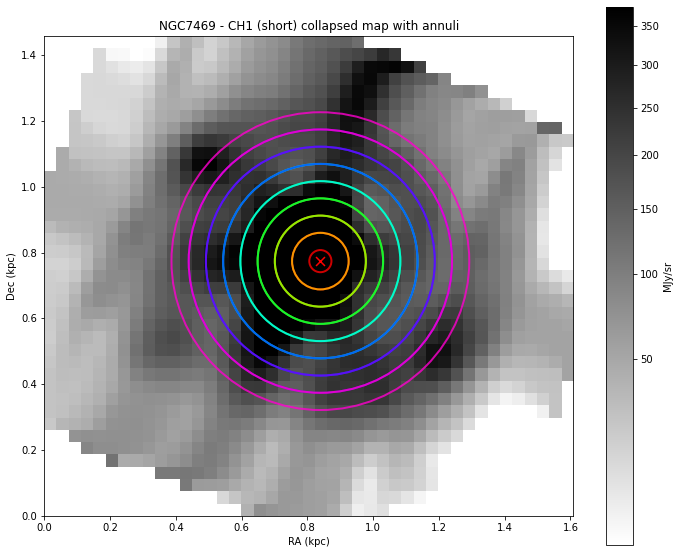

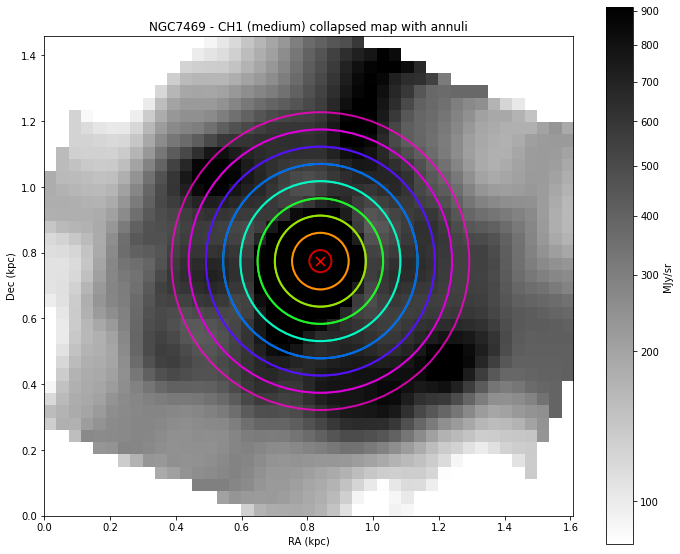

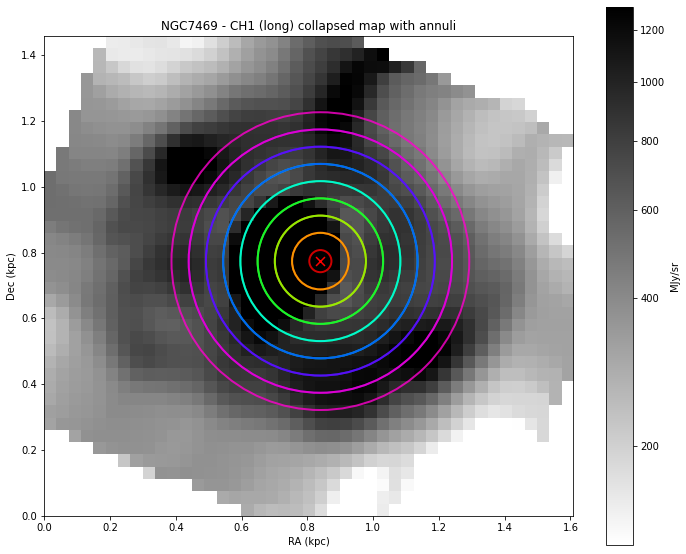

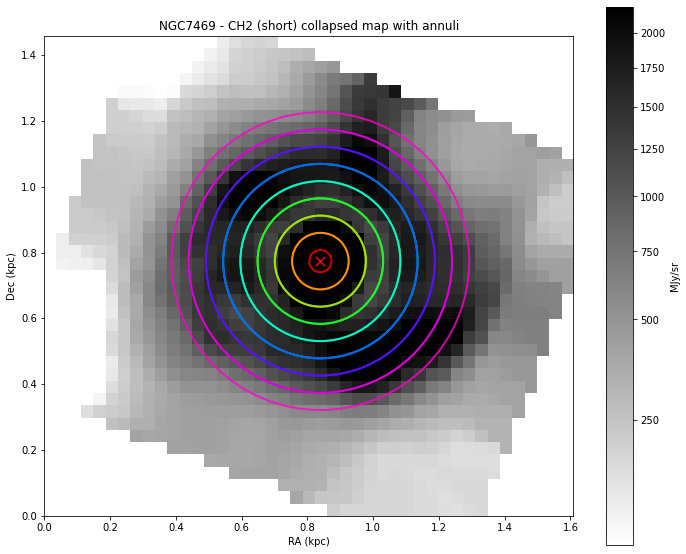

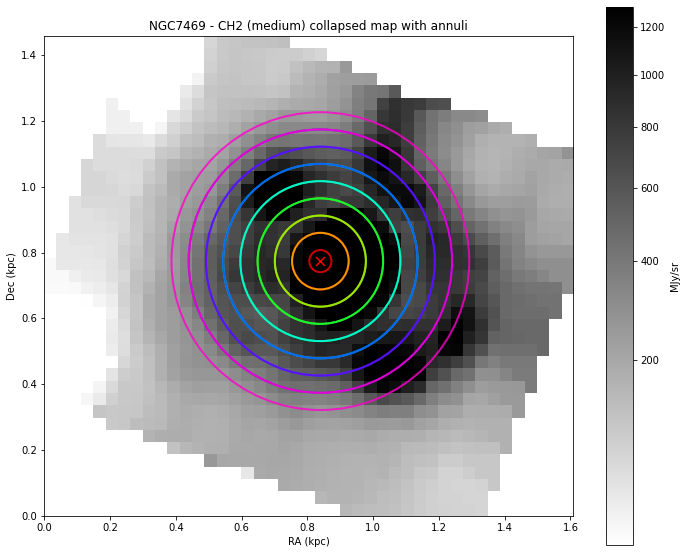

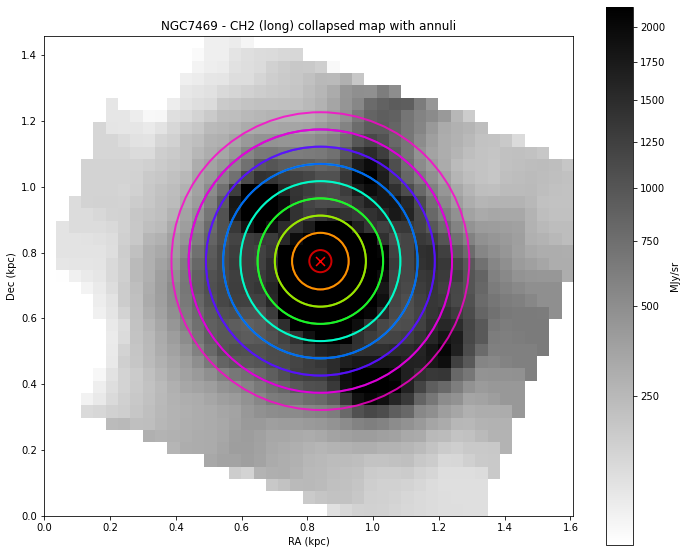

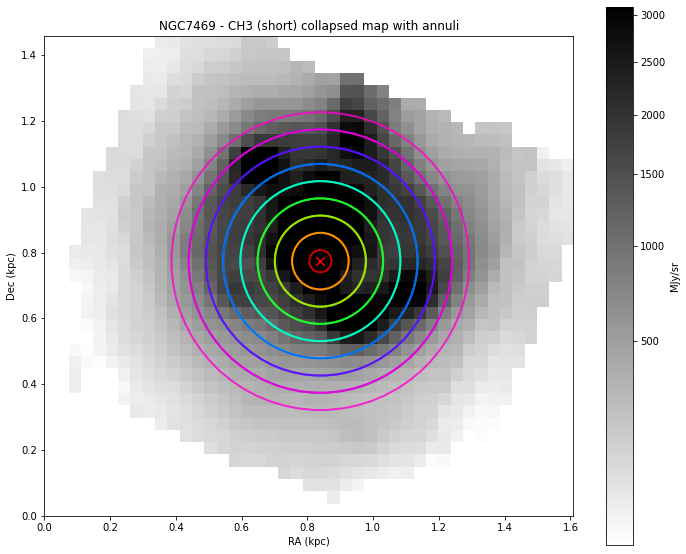

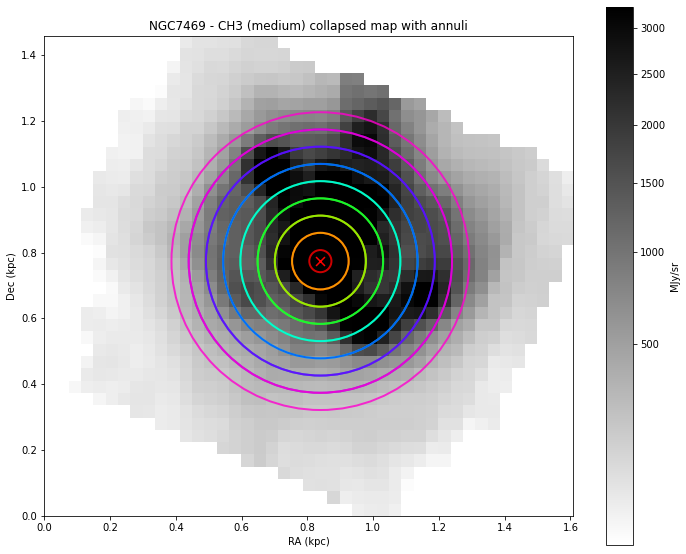

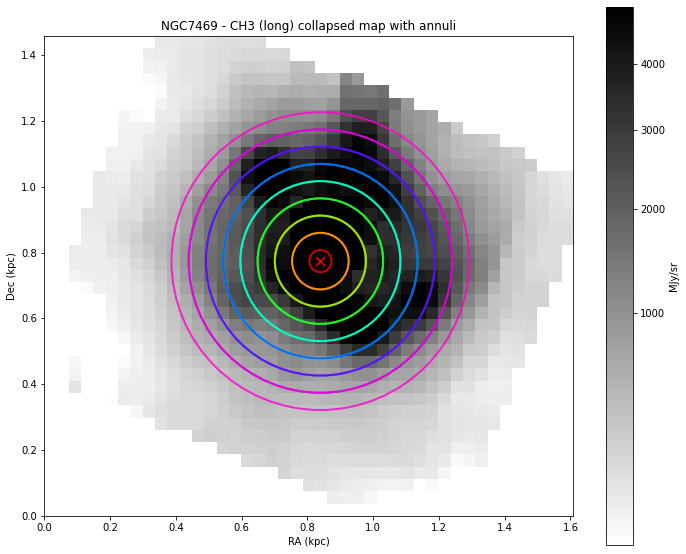

[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-short_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring1.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring2.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring3.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring4.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring5.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring6.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring7.fits
[MultiSpecModel] Saved: NGC7469_CH1-medium_Ring8.fits
[MultiSpecModel] Saved: NGC7469_CH1-long_Ring1.fits
[Mu

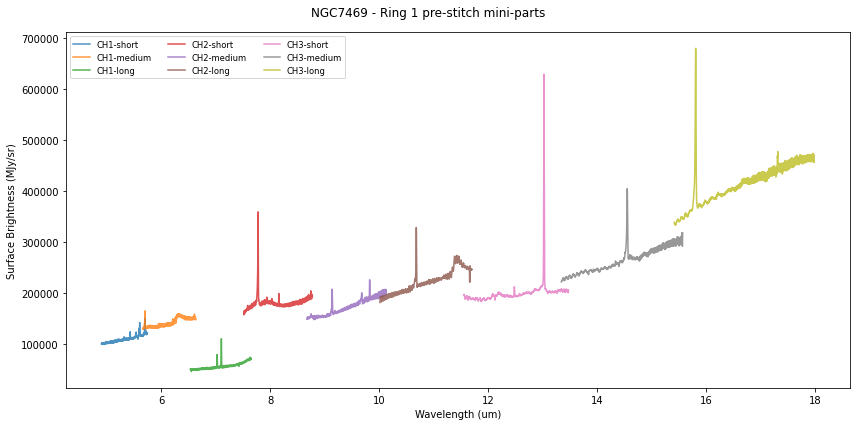

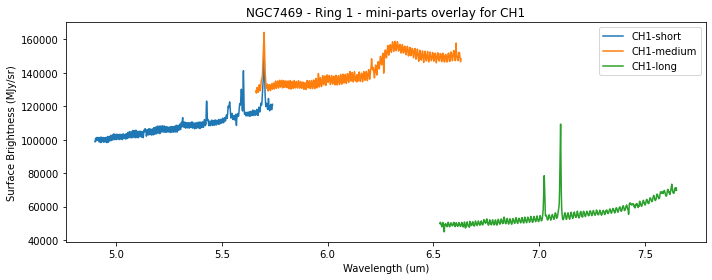

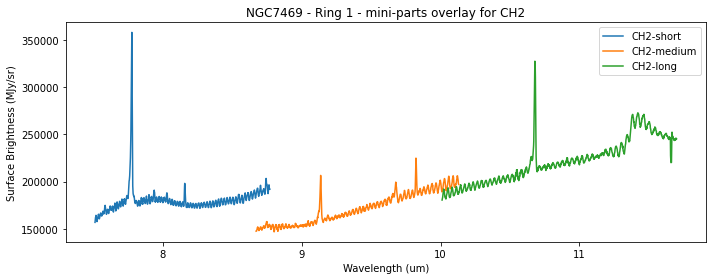

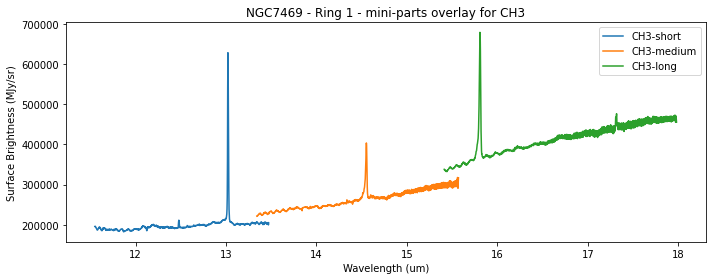

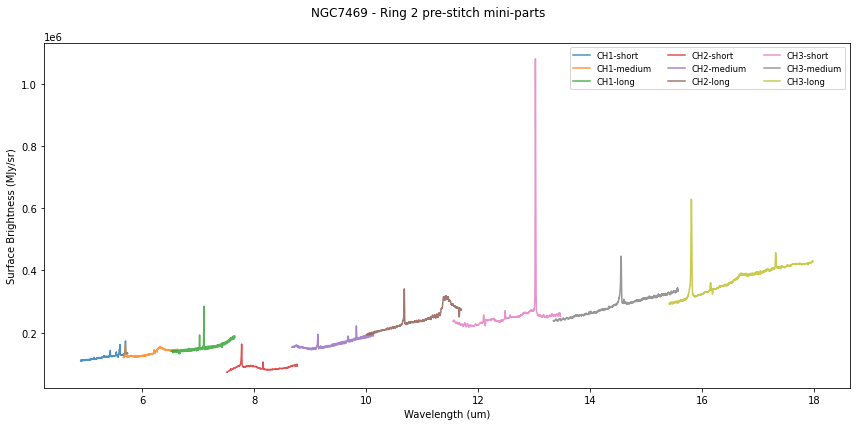

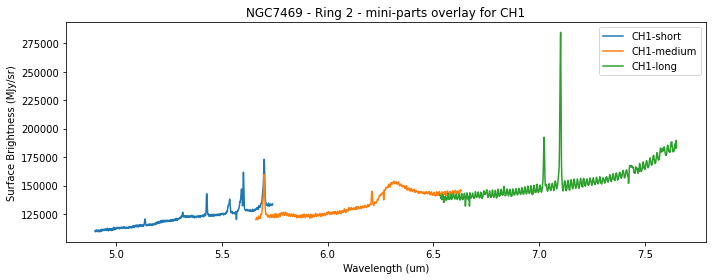

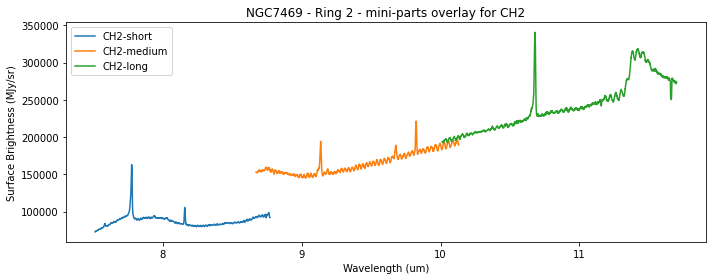

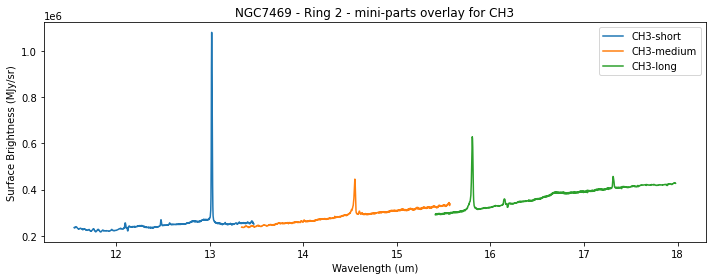

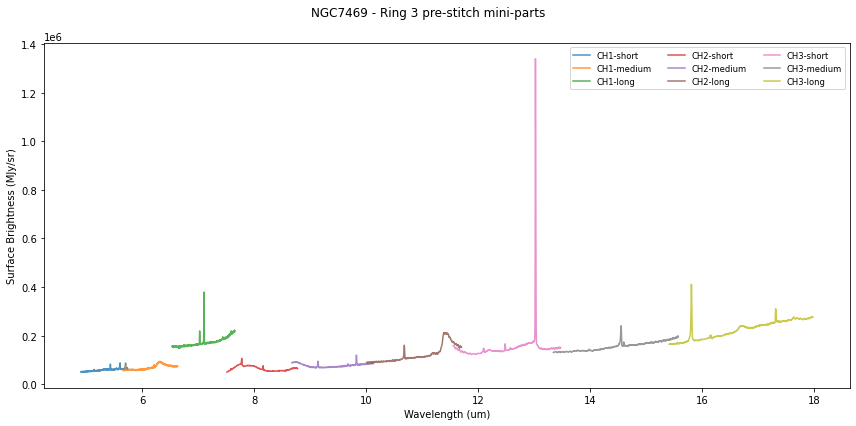

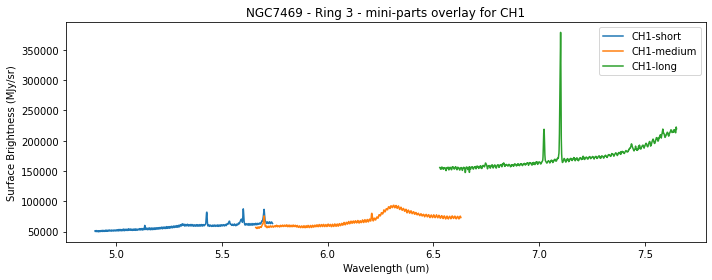

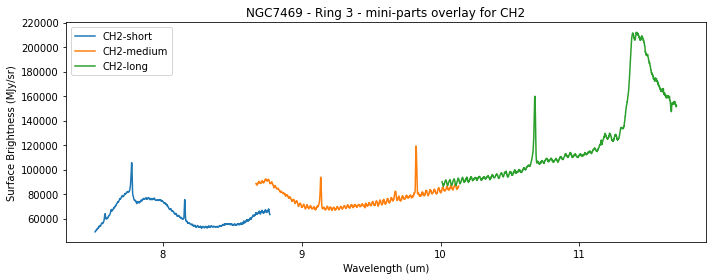

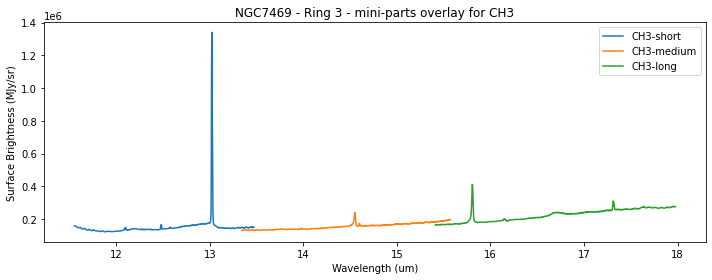

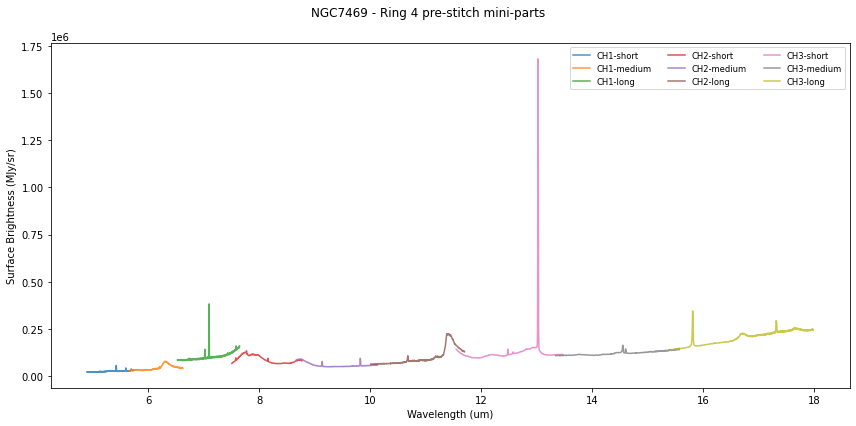

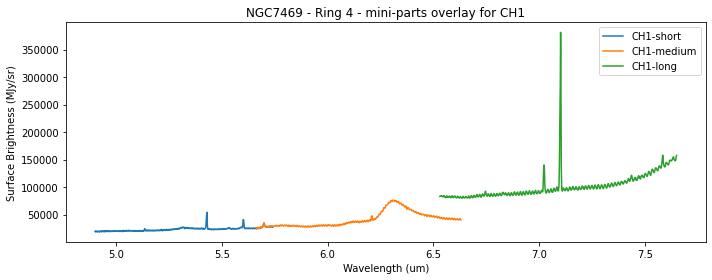

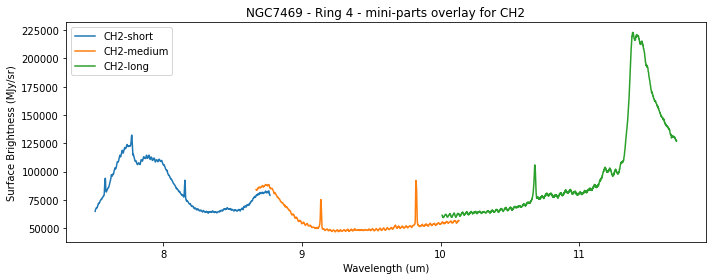

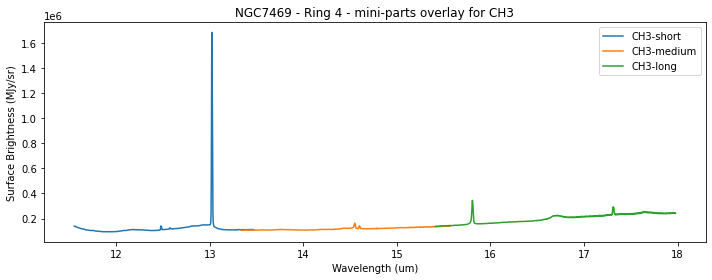

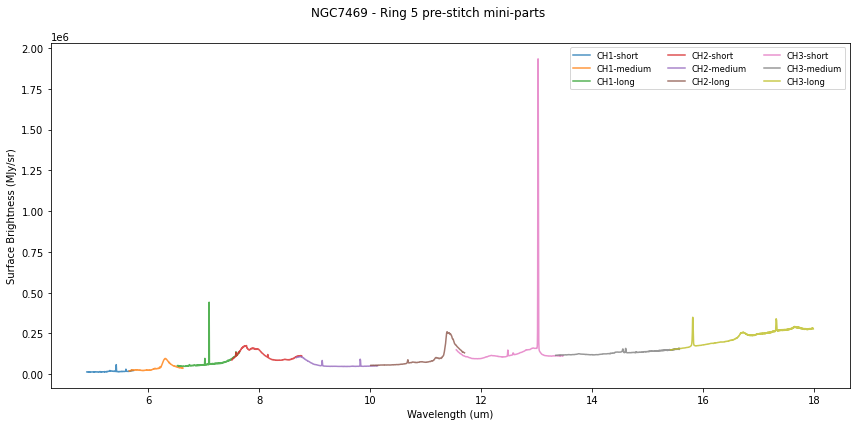

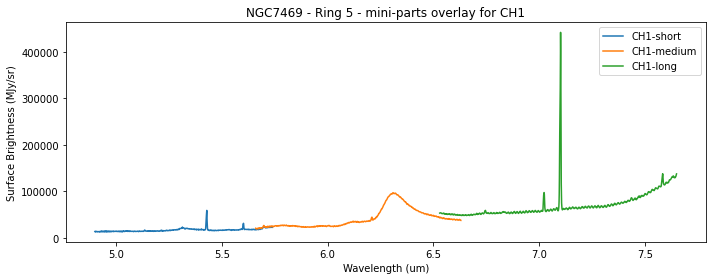

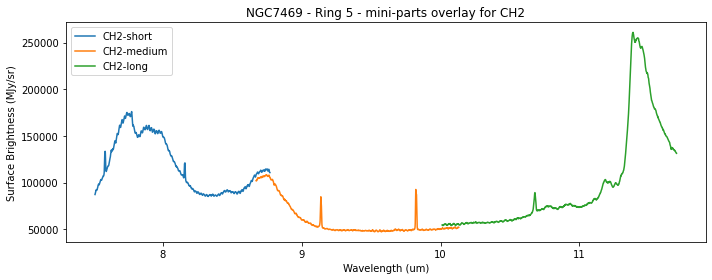

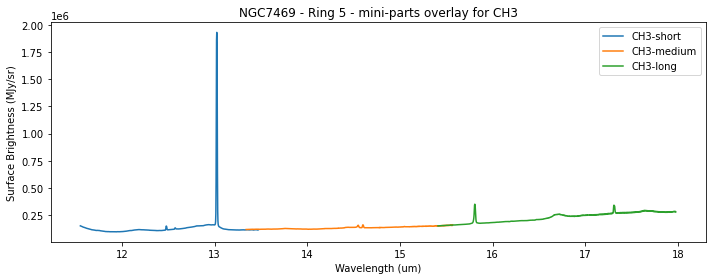

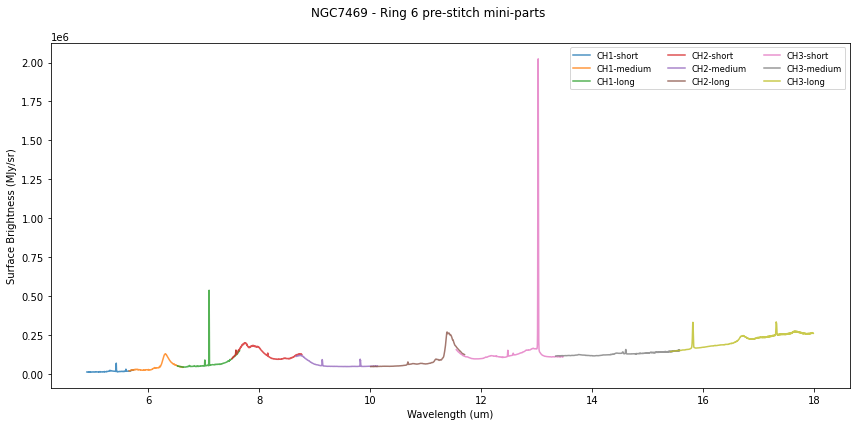

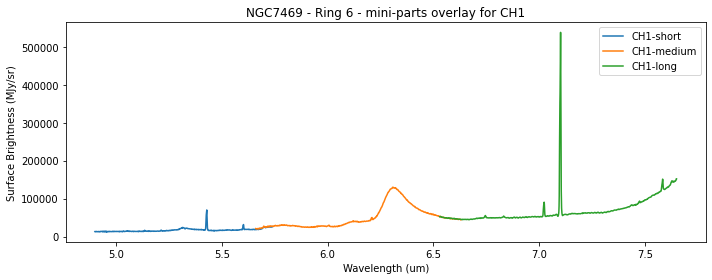

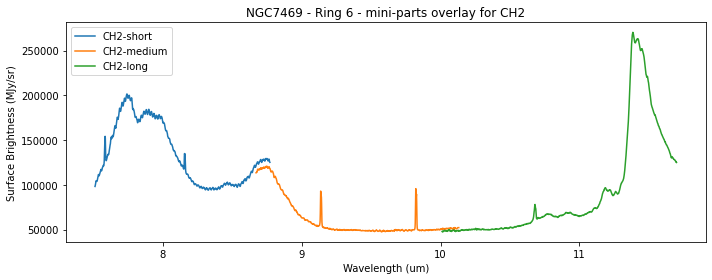

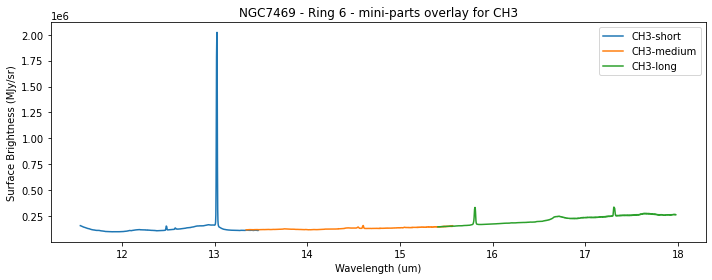

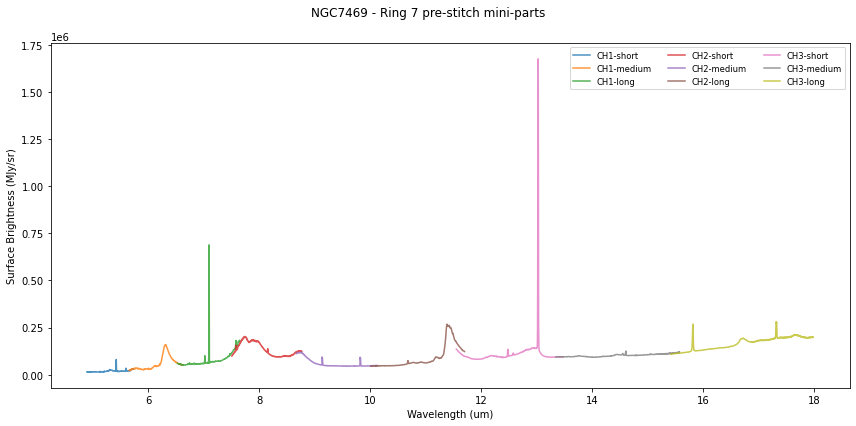

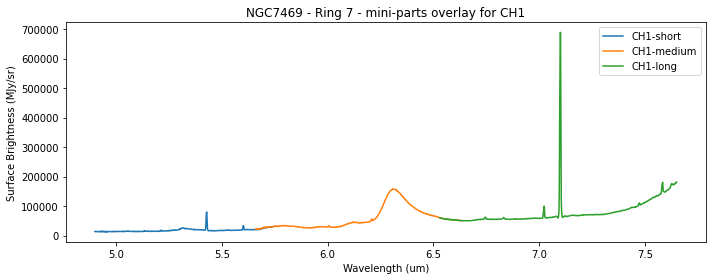

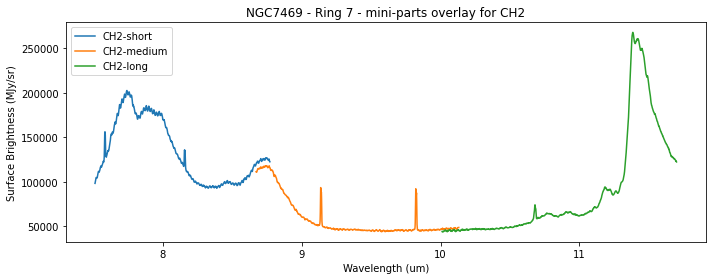

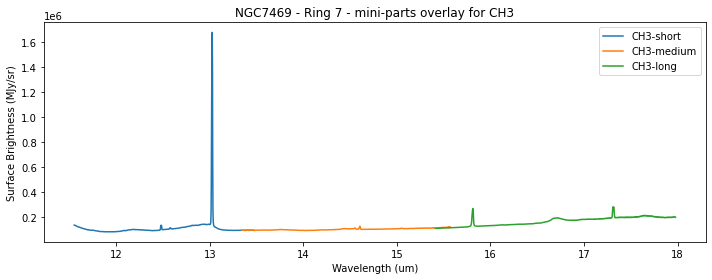

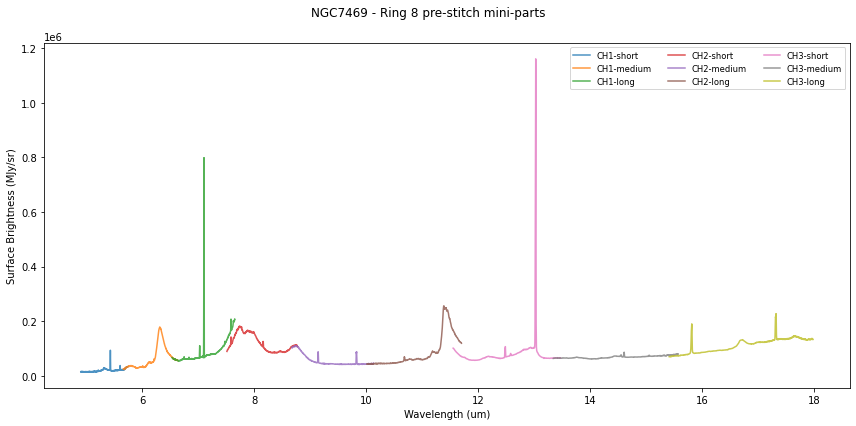

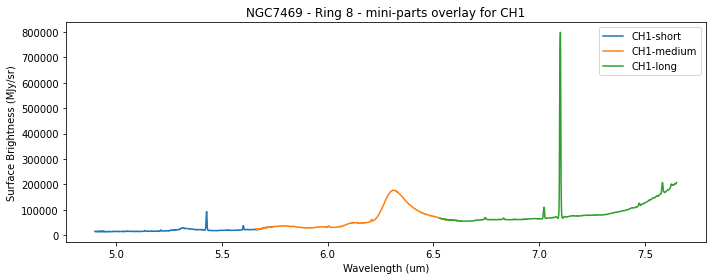

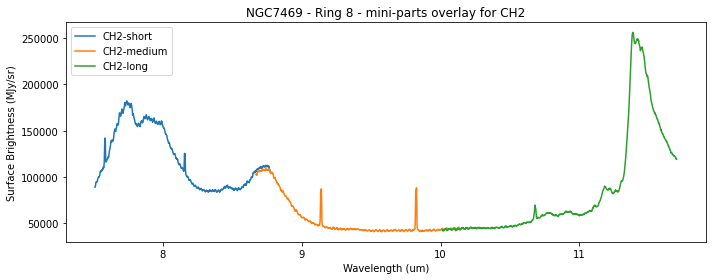

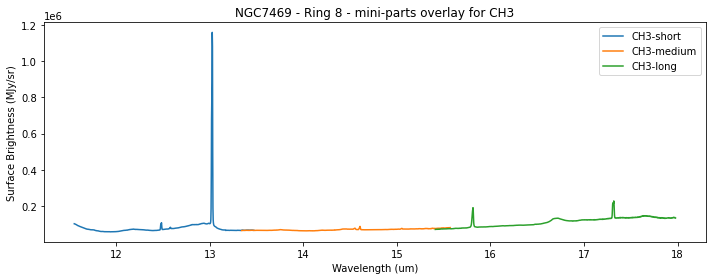

[INFO] Manual overlap-matched stitching of all mini-parts per ring ...
[STITCHED] Ring 1 → NGC7469_Ring1_stitched_manual.fits (8669 points)


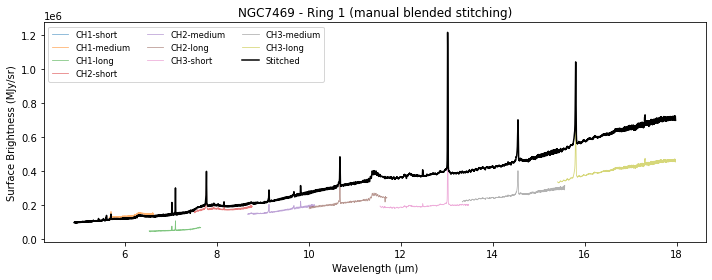

[STITCHED] Ring 2 → NGC7469_Ring2_stitched_manual.fits (8669 points)


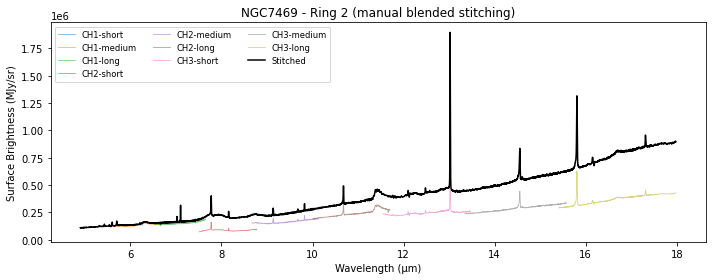

[STITCHED] Ring 3 → NGC7469_Ring3_stitched_manual.fits (8669 points)


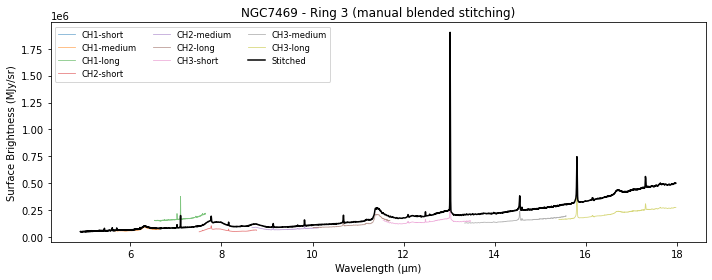

[STITCHED] Ring 4 → NGC7469_Ring4_stitched_manual.fits (8669 points)


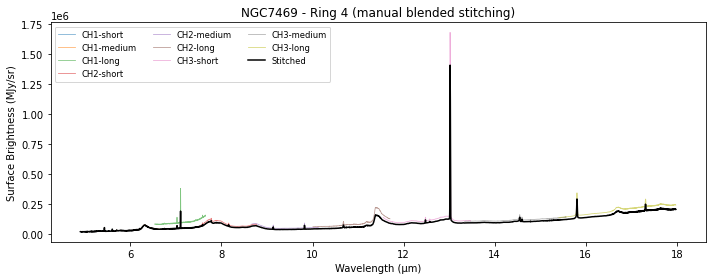

[STITCHED] Ring 5 → NGC7469_Ring5_stitched_manual.fits (8669 points)


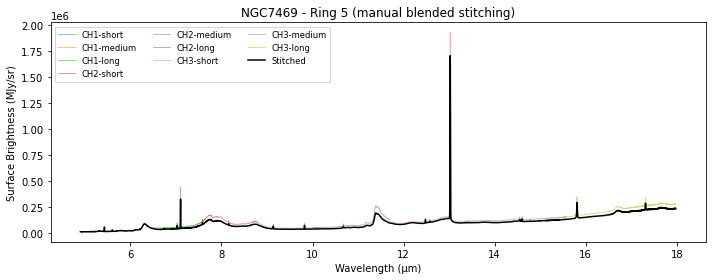

[STITCHED] Ring 6 → NGC7469_Ring6_stitched_manual.fits (8669 points)


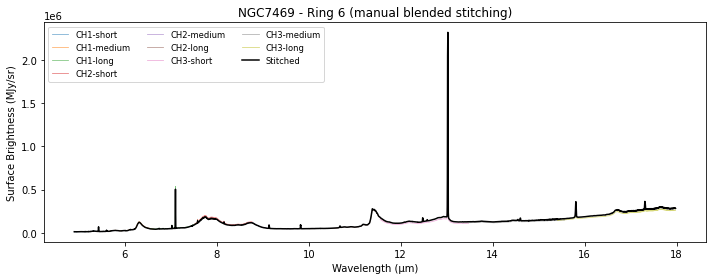

[STITCHED] Ring 7 → NGC7469_Ring7_stitched_manual.fits (8669 points)


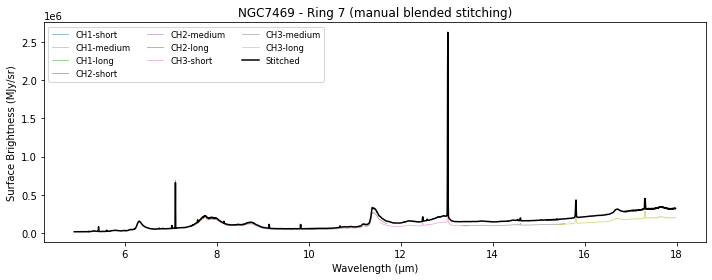

[STITCHED] Ring 8 → NGC7469_Ring8_stitched_manual.fits (8669 points)


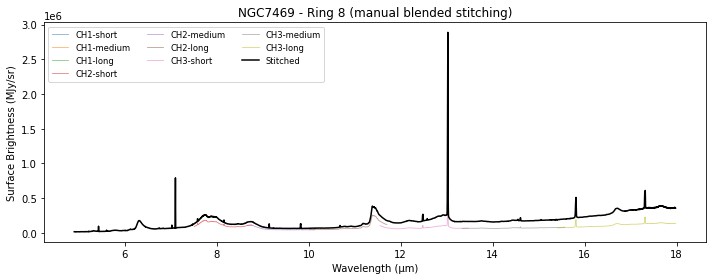

In [1]:
#!/usr/bin/env python3
"""
Unified extraction + one-step stitching script.
- Select galaxy_folder (contains the _s3d.fits cubes: CH1/CH2/CH3 with short/medium/long or combined).
- Script extracts annuli from every mini-cube, saves MultiSpecModel rings,
  stitches ALL available mini-parts per ring in one Combine1dStep call,
  writes simplified 1D PAHFIT-ready FITS, and shows diagnostics.
"""

import os
import json
import warnings
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.table import Table, Column
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import simple_norm
from astropy import units as u

import matplotlib.pyplot as plt
from matplotlib import colormaps
from photutils.aperture import aperture_photometry, CircularAnnulus

from jwst.combine_1d import Combine1dStep
from jwst.datamodels import MultiSpecModel

warnings.filterwarnings("ignore")

# ------------------- USER: select galaxy folder here -------------------
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
galaxy_name = galaxy_folder.name

# environment for JWST (optional)
os.environ['CRDS_PATH'] = os.path.expanduser("~/crds_cache")
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# ------------------- PARAMETERS (keep as before) -------------------
pixel_scale_arcsec = 0.11
pixel_scale_pc = 37.41
pixel_scale_kpc = pixel_scale_pc / 1000.0

effective_fwhm = {'CH1': 0.22, 'CH2': 0.28, 'CH3': 0.66}  # arcsec
target_fwhm = 0.30  # arcsec
sigma_from_fwhm = lambda f: f / (2.0 * np.sqrt(2.0 * np.log(2.0)))

r0 = 0.9
step = 1.4
num_rings = 8
annuli_radii = [(r0 + i*step, r0 + (i+1)*step) for i in range(num_rings)]

# order for final stitching (per-ring): CH1 short/med/long, CH2..., CH3...
stitch_order = [
    ('CH1','short'), ('CH1','medium'), ('CH1','long'),
    ('CH2','short'), ('CH2','medium'), ('CH2','long'),
    ('CH3','short'), ('CH3','medium'), ('CH3','long'),
]

# ------------------- Helper: find cube for (channel, part) -------------------
def find_cube_for(ch_label, part_label, all_files):
    """
    Look for a filename in all_files that corresponds to channel ch_label ('CH1') and part_label ('short','medium','long').
    Accepts names containing 'ch1' (case-insensitive) and 'short' (or 'shortmediumlong' or 's3d' combos).
    Returns Path or None.
    """
    ch_frag = ch_label.lower()  # 'ch1'
    part_frag = part_label.lower()  # 'short'
    # Look for exact match first (both substrings present)
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and part_frag in name:
            return f
    # If no exact, allow 'shortmediumlong' full-band to satisfy any part
    for f in all_files:
        name = f.name.lower()
        if ch_frag in name and ('shortmediumlong' in name or 'shortmedlong' in name or 'shortmedium' in name):
            return f
    # No file
    return None

# ------------------- Function to save ring as MultiSpecModel -------------------
def save_ring_multispec(filename_path: Path, wavelengths, flux):
    n = len(wavelengths)
    spec_table = Table()
    spec_table['WAVELENGTH'] = Column(wavelengths, unit='um')
    spec_table['FLUX'] = Column(flux, unit='MJy/sr')
    spec_table['FLUX_ERROR'] = Column(np.ones(n)*0.1, unit='MJy/sr')
    spec_table['DQ'] = np.zeros(n, dtype=np.uint32)
    for col in ['FLUX_VAR_POISSON','FLUX_VAR_RNOISE','FLUX_VAR_FLAT','SURF_BRIGHT','SB_ERROR',
                'SB_VAR_POISSON','SB_VAR_RNOISE','SB_VAR_FLAT','BACKGROUND','BKGD_ERROR','BKGD_VAR_POISSON',
                'BKGD_VAR_RNOISE','BKGD_VAR_FLAT','NPIXELS']:
        spec_table[col] = np.zeros(n)
    model = MultiSpecModel()
    model.spec = [{"spec_table": spec_table}]
    model.meta.instrument.name = 'MIRI'
    model.meta.exposure.type = 'MIR_MRS'
    model.meta.exposure.exposure_time = 1.0
    model.meta.bunit_data = 'MJy/sr'
    model.save(str(filename_path), overwrite=True)
    print(f"[MultiSpecModel] Saved: {filename_path.name}")

# ------------------- Gather available cubes -------------------
all_cube_files = sorted(galaxy_folder.glob("*_s3d.fits"))
if len(all_cube_files) == 0:
    raise FileNotFoundError(f"No '*_s3d.fits' files found in {galaxy_folder}")

print(f"[INFO] Found {len(all_cube_files)} cube(s) in {galaxy_folder}:")
for f in all_cube_files:
    print(" -", f.name)

# Build a lookup of available mini-cubes per (CHx, part)
mini_cubes = {}  # key (CH1,'short') -> Path
for ch, part in stitch_order:
    found = find_cube_for(ch, part, all_cube_files)
    if found is not None:
        mini_cubes[(ch, part)] = found

# Also allow detection of 'CH1' full-band files (shortmediumlong)
for f in all_cube_files:
    name = f.name.lower()
    if 'ch1' in name and 'shortmediumlong' in name:
        mini_cubes[('CH1','full')] = f
    if 'ch2' in name and 'shortmediumlong' in name:
        mini_cubes[('CH2','full')] = f
    if 'ch3' in name and 'shortmediumlong' in name:
        mini_cubes[('CH3','full')] = f

print("[INFO] Available mini-cubes:")
for k,v in mini_cubes.items():
    print(f"  {k}: {v.name}")

# ------------------- Load all mini-cubes: extract data, wavelengths, collapsed image -------------------
cubes = {}             # key -> (data[z,y,x], wavelengths array in um)
collapsed_map = {}     # key -> 2D collapsed mean
min_shape = None

for (ch, part), filepath in mini_cubes.items():
    hdul = fits.open(filepath)
    data = hdul[1].data.astype(np.float64)  # (nz, ny, nx)
    header = hdul[1].header
    wl_start = header.get('CRVAL3', header.get('CRVAL', None))
    wl_step  = header.get('CDELT3', header.get('CDELT', None))
    if wl_start is None or wl_step is None:
        # try alternative header keywords; fail if not found
        raise KeyError(f"No CRVAL3/CDELT3 in header of {filepath.name}")
    wavelengths = wl_start + np.arange(data.shape[0]) * wl_step
    # PSF match if necessary based on channel (use channel's effective_fwhm)
    eff_fwhm = effective_fwhm.get(ch, None)
    if eff_fwhm is not None and eff_fwhm < target_fwhm:
        sigma_target = sigma_from_fwhm(target_fwhm)
        sigma_eff = sigma_from_fwhm(eff_fwhm)
        sigma_conv_arcsec = np.sqrt(max(sigma_target**2 - sigma_eff**2, 0.0))
        sigma_pix = sigma_conv_arcsec / pixel_scale_arcsec
        data = np.array([
            convolve(plane, Gaussian2DKernel(sigma_pix), boundary='extend', nan_treatment='interpolate')
            for plane in data
        ])
        print(f"[{ch}|{part}] PSF matched -> target {target_fwhm}\" (sigma_pix={sigma_pix:.3f})")
    collapsed = np.nanmean(data, axis=0)
    cubes[(ch,part)] = (data, wavelengths)
    collapsed_map[(ch,part)] = collapsed
    if min_shape is None:
        min_shape = collapsed.shape
    else:
        min_shape = (min(min_shape[0], collapsed.shape[0]),
                     min(min_shape[1], collapsed.shape[1]))

# Center-crop all collapsed maps & cube data to min_shape
for key in list(collapsed_map.keys()):
    img = collapsed_map[key]
    y_trim = (img.shape[0] - min_shape[0]) // 2
    x_trim = (img.shape[1] - min_shape[1]) // 2
    collapsed_map[key] = img[y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]]
    data, wl = cubes[key]
    cubes[key] = (data[:, y_trim:y_trim+min_shape[0], x_trim:x_trim+min_shape[1]], wl)

# ------------------- Compute common photometric center from combined image -------------------
combined_image = sum(img - np.nanmin(img) for img in collapsed_map.values())
mask = np.isfinite(combined_image)
total = np.nansum(combined_image[mask])
y_idx, x_idx = np.indices(combined_image.shape)
x_center = np.nansum(x_idx[mask] * combined_image[mask]) / total
y_center = np.nansum(y_idx[mask] * combined_image[mask]) / total
print(f"[CENTER] common center (px): x={x_center:.2f}, y={y_center:.2f}")

# ------------------- 2D visualization: show collapsed maps with annuli (per mini-cube) -------------------
cmap = colormaps.get_cmap('hsv')
for key, img in collapsed_map.items():
    ch, part = key
    plt.figure(figsize=(10,8))
    norm = simple_norm(img, 'sqrt', percent=88)
    extent_x_kpc = img.shape[1] * pixel_scale_kpc
    extent_y_kpc = img.shape[0] * pixel_scale_kpc
    plt.imshow(img, origin='lower', cmap='binary', norm=norm,
               extent=[0, extent_x_kpc, 0, extent_y_kpc])
    plt.colorbar(label='MJy/sr')
    # plot annuli in kpc coordinates
    annuli_kpc = [(r_in*pixel_scale_kpc, r_out*pixel_scale_kpc) for r_in,r_out in annuli_radii]
    cx_kpc = x_center * pixel_scale_kpc
    cy_kpc = y_center * pixel_scale_kpc
    for i,(rin, rout) in enumerate(annuli_kpc):
        ann = CircularAnnulus((cx_kpc, cy_kpc), r_in=rin, r_out=rout)
        ann.plot(color=cmap(i/len(annuli_kpc)), lw=2, alpha=0.8)
    plt.scatter(cx_kpc, cy_kpc, color='red', marker='x', s=80)
    plt.title(f"{galaxy_name} - {ch} ({part}) collapsed map with annuli")
    plt.xlabel("RA (kpc)")
    plt.ylabel("Dec (kpc)")
    plt.tight_layout()
    plt.show()

# ------------------- Extract annuli from each mini-cube and save MultiSpecModel rings -------------------
print("[INFO] Extracting annular spectra from each mini-cube and saving MultiSpecModel rings...")
for (ch, part), (data, wavelengths) in cubes.items():
    for i, (r_in, r_out) in enumerate(annuli_radii):
        ann_ap = CircularAnnulus((x_center, y_center), r_in=r_in, r_out=r_out)
        flux = np.array([aperture_photometry(plane, ann_ap)['aperture_sum'][0] for plane in data])
        ring_idx = i+1
        # filename pattern: GALAXY_CH1-short_Ring1.fits
        ring_filename = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_idx}.fits"
        save_ring_multispec(ring_filename, wavelengths, flux)

# ------------------- Pre-stitch plots: show mini-parts for a chosen ring (and overlay per channel) -------------------
# (Plot per ring across mini-parts to inspect continuity.)
for ring_number in range(1, num_rings+1):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{galaxy_name} - Ring {ring_number} pre-stitch mini-parts")
    ax1 = plt.subplot(1,1,1)
    for (ch, part), (data, wavelengths) in cubes.items():
        # read the saved MultiSpecModel ring file to get flux (or recompute directly)
        ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if not ring_file.exists():
            continue
        model = MultiSpecModel(str(ring_file))
        tbl = model.spec[0].spec_table
        wl = tbl['WAVELENGTH']
        fl = tbl['FLUX']
        ax1.plot(wl, fl, label=f"{ch}-{part}", alpha=0.8)
    ax1.set_xlabel("Wavelength (um)")
    ax1.set_ylabel("Surface Brightness (MJy/sr)")
    ax1.legend(ncol=3, fontsize='small')
    plt.tight_layout()
    plt.show()

    # Overlay per channel (CH1 parts together etc.)
    for ch in ['CH1','CH2','CH3']:
        plt.figure(figsize=(10,4))
        for part in ['short','medium','long','full']:
            ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
            if not ring_file.exists():
                # also accept "full" naming without '-full' if file existed as CH1_shortmediumlong
                continue
            model = MultiSpecModel(str(ring_file))
            tbl = model.spec[0].spec_table
            plt.plot(tbl['WAVELENGTH'], tbl['FLUX'], label=f"{ch}-{part}")
        plt.title(f"{galaxy_name} - Ring {ring_number} - mini-parts overlay for {ch}")
        plt.xlabel("Wavelength (um)")
        plt.ylabel("Surface Brightness (MJy/sr)")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
# ------------------- MANUAL CONTINUITY-STITCHING (no JWST pipeline) -------------------
from scipy.interpolate import interp1d

def join_spectra(w1, f1, w2, f2):
    """
    Join two spectra with overlap scaling and blending.
    Returns concatenated wavelength and flux arrays.
    """
    # Ensure increasing wavelength
    if w1[0] > w1[-1]:
        w1, f1 = w1[::-1], f1[::-1]
    if w2[0] > w2[-1]:
        w2, f2 = w2[::-1], f2[::-1]

    w1_end, w2_start = w1[-1], w2[0]
    # detect overlap
    overlap_start = max(w1[0], w2[0])
    overlap_end   = min(w1[-1], w2[-1])
    overlap = overlap_end > overlap_start

    if not overlap:
        # no overlap → direct concatenation
        w_combined = np.concatenate([w1, w2])
        f_combined = np.concatenate([f1, f2])
        return w_combined, f_combined

    # Define overlap regions
    overlap_mask1 = (w1 >= overlap_start) & (w1 <= overlap_end)
    overlap_mask2 = (w2 >= overlap_start) & (w2 <= overlap_end)

    if np.sum(overlap_mask1) < 3 or np.sum(overlap_mask2) < 3:
        # small overlap
        w_combined = np.concatenate([w1, w2])
        f_combined = np.concatenate([f1, f2])
        return w_combined, f_combined

    # Compute scale factor to match mean flux
    f1_mean = np.nanmedian(f1[overlap_mask1])
    f2_mean = np.nanmedian(f2[overlap_mask2])
    scale = f1_mean / f2_mean if (f2_mean != 0 and np.isfinite(f2_mean)) else 1.0
    f2_scaled = f2 * scale

    # Blend in overlap
    interp1 = interp1d(w1, f1, bounds_error=False, fill_value="extrapolate")
    interp2 = interp1d(w2, f2_scaled, bounds_error=False, fill_value="extrapolate")

    w_overlap = np.linspace(overlap_start, overlap_end, 50)
    blend = np.linspace(0, 1, 50)
    flux_overlap = (1 - blend) * interp1(w_overlap) + blend * interp2(w_overlap)

    # Concatenate: before-overlap (from 1), blended overlap, after-overlap (from 2)
    w_combined = np.concatenate([
        w1[w1 < overlap_start],
        w_overlap,
        w2[w2 > overlap_end]
    ])
    f_combined = np.concatenate([
        f1[w1 < overlap_start],
        flux_overlap,
        f2_scaled[w2 > overlap_end]
    ])
    return w_combined, f_combined


# MAIN LOOP — one ring at a time
print("[INFO] Manual overlap-matched stitching of all mini-parts per ring ...")

for ring_number in range(1, num_rings + 1):
    ring_parts = []
    for (ch, part) in stitch_order:
        ring_file = galaxy_folder / f"{galaxy_name}_{ch}-{part}_Ring{ring_number}.fits"
        if ring_file.exists():
            model = MultiSpecModel(str(ring_file))
            tab = model.spec[0].spec_table
            ring_parts.append((np.array(tab['WAVELENGTH']), np.array(tab['FLUX']), f"{ch}-{part}"))

    if len(ring_parts) == 0:
        print(f"[SKIP] Ring {ring_number}: no parts found.")
        continue

    # Sort by wavelength start
    ring_parts.sort(key=lambda x: x[0][0])

    # Progressive joining
    w_comb, f_comb = ring_parts[0][0], ring_parts[0][1]
    for j in range(1, len(ring_parts)):
        w_next, f_next, label = ring_parts[j]
        w_comb, f_comb = join_spectra(w_comb, f_comb, w_next, f_next)

    # Save stitched ring
    stitched_file = galaxy_folder / f"{galaxy_name}_Ring{ring_number}_stitched_manual.fits"
    n = len(w_comb)
    tab = Table()
    tab['wavelength'] = Column(w_comb, unit='um')
    tab['flux'] = Column(f_comb, unit='MJy/sr')
    tab.write(stitched_file, format='fits', overwrite=True)
    print(f"[STITCHED] Ring {ring_number} → {stitched_file.name} ({n} points)")

    # Diagnostic plot
    plt.figure(figsize=(10,4))
    for w, f, label in ring_parts:
        plt.plot(w, f, alpha=0.6, lw=0.8, label=label)
    plt.plot(w_comb, f_comb, color='black', lw=1.5, label='Stitched')
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Surface Brightness (MJy/sr)")
    plt.title(f"{galaxy_name} - Ring {ring_number} (manual blended stitching)")
    plt.legend(fontsize='small', ncol=3)
    plt.tight_layout()
    plt.show()
